In [1]:
from astropy.io import fits
import tayph.operations as ops
import matplotlib.pyplot as plt
import numpy as np
import tayph.system_parameters as sp
import astropy.units as u
import astropy.constants as const
import scipy.interpolate as interp
from astropy import constants as C
import narrow_spectrum
from scipy.interpolate import interp1d
import pickle
import sys

sys.path.insert(0, "/home/madeline/StarRotator")  # change to package from path later
from StarRotator import StarRotator

# Systemic velocity
beta1 = (22.4) * 1e3 / C.c.value
doppler_shift1 = np.sqrt((1 + beta1) / (1 - beta1))

# Transit parameters from Lendl and Deline
RpRs = 0.074  # Bibi
u1 = 0.344  # pysme
u2 = 0.263
# Calculate planet position!
a_Rs = 4.6  # deline
inc = 84.58 * np.pi / 180  # deline+22
obl = 90.07 * np.pi / 180  # bibi
vsini = 95.05e3  # bibi

In [2]:
snr = np.load("HARPS_snr_3transits.npy")

In [3]:
wl_all_Fe = []
FstarN_all_Fe = []

In [4]:
wl_night1 = []
FstarN_night1 = []

wl_night2 = []
FstarN_night2 = []

wl_night3 = []
FstarN_night3 = []

In [5]:
wl_all_broad = []
flux_all_broad = []

In [6]:
with open("/data/madeline/pickle-jar/WASP189_HARPS_night1.pkl", "rb") as file:
    WASP189_night1 = pickle.load(file)

In [7]:
model = np.load("MAROONX_lines_broadened_pysme.npy")
wl_model = model[0, :]
flux_model = model[1, :]

In [8]:
model = np.load("MAROONX_lines_narrow_noiseless.npy")
wl_model_narrow = model[0, :]
flux_model_narrow = model[1, :]

In [9]:
MAROONX_lines = np.load("MAROONX_lines_narrow_3transit.npy")
wl_synth = MAROONX_lines[0, :]
flux_synth = MAROONX_lines[1, :]

In [3]:
dp = "HARPS_W189/tayph_output/data/WASP-189/night2/"
with fits.open(dp + "flux_norm_0.fits") as f:
    # header_all.append(f[0].header)
    flux2 = f[0].data

with fits.open(dp + "wl_cor_0.fits") as f:
    # header_all.append(f[0].header)
    wl2 = f[0].data

phases2 = sp.phase(
    "/home/madeline/masters-project/HARPS_W189/tayph_output/data/WASP-189/night2/"
)
transit2 = sp.transit(
    "/home/madeline/masters-project/HARPS_W189/tayph_output/data/WASP-189/night2/"
)
out_of_transit_idx2 = np.argwhere(transit2 == 1)
in_transit_idx2 = np.argwhere(transit2 != 1)

true_anom = 2 * np.pi * phases2

x_pl = a_Rs * np.sin(true_anom)
y_pl = -a_Rs * np.cos(true_anom) * np.cos(inc)
z_pl = a_Rs * np.cos(true_anom) * np.sin(inc)

xp2 = x_pl * np.cos(obl) - y_pl * np.sin(obl)
yp2 = x_pl * np.sin(obl) + y_pl * np.cos(obl)
zp2 = z_pl

In [4]:
dp = "HARPS_W189/tayph_output/data/WASP-189/night1/"
with fits.open(dp + "flux_norm_0.fits") as f:
    # header_all.append(f[0].header)
    flux1 = f[0].data

with fits.open(dp + "wl_cor_0.fits") as f:
    # header_all.append(f[0].header)
    wl1 = f[0].data

phases1 = sp.phase(
    "/home/madeline/masters-project/HARPS_W189/tayph_output/data/WASP-189/night1/"
)
transit1 = sp.transit(
    "/home/madeline/masters-project/HARPS_W189/tayph_output/data/WASP-189/night1/"
)
out_of_transit_idx1 = np.argwhere(transit1 == 1)
in_transit_idx1 = np.argwhere(transit1 != 1)

# Calculate planet position!
true_anom = 2 * np.pi * phases1

x_pl = a_Rs * np.sin(true_anom)
y_pl = -a_Rs * np.cos(true_anom) * np.cos(inc)
z_pl = a_Rs * np.cos(true_anom) * np.sin(inc)

xp1 = x_pl * np.cos(obl) - y_pl * np.sin(obl)
yp1 = x_pl * np.sin(obl) + y_pl * np.cos(obl)
zp1 = z_pl

In [5]:
dp = "HARPS_W189/tayph_output/data/WASP-189/night3/"
with fits.open(dp + "flux_norm_0.fits") as f:
    # header_all.append(f[0].header)
    flux3 = f[0].data

with fits.open(dp + "wl_cor_0.fits") as f:
    # header_all.append(f[0].header)
    wl3 = f[0].data

phases3 = sp.phase(
    "/home/madeline/masters-project/HARPS_W189/tayph_output/data/WASP-189/night3/"
)
transit3 = sp.transit(
    "/home/madeline/masters-project/HARPS_W189/tayph_output/data/WASP-189/night3/"
)
out_of_transit_idx3 = np.argwhere(transit3 == 1)
in_transit_idx3 = np.argwhere(transit3 != 1)

# Calculate planet position!
true_anom = 2 * np.pi * phases3

x_pl = a_Rs * np.sin(true_anom)
y_pl = -a_Rs * np.cos(true_anom) * np.cos(inc)
z_pl = a_Rs * np.cos(true_anom) * np.sin(inc)

xp3 = x_pl * np.cos(obl) - y_pl * np.sin(obl)
yp3 = x_pl * np.sin(obl) + y_pl * np.cos(obl)
zp3 = z_pl

Mean out of transit spectrum for 3 transits

In [6]:
wl = ops.vactoair(wl2) * doppler_shift1

meanspec1 = np.nanmean(flux1[out_of_transit_idx1], axis=0)
meanspec2 = np.nanmean(flux2[out_of_transit_idx2], axis=0)
meanspec3 = np.nanmean(flux3[out_of_transit_idx3], axis=0)

meanspec1 /= np.nanmean(meanspec1)
meanspec2 /= np.nanmean(meanspec2)
meanspec3 /= np.nanmean(meanspec3)

meanspec1_interp = interp1d(
    ops.vactoair(wl1) * doppler_shift1, meanspec1, bounds_error=False
)(wl)
meanspec3_interp = interp1d(
    ops.vactoair(wl3) * doppler_shift1, meanspec3, bounds_error=False
)(wl)

meanspec = np.nanmean((meanspec1_interp, meanspec2, meanspec3_interp), axis=0)

/tmp/ipykernel_3858408/1342182943.py:3: RuntimeWarning: Mean of empty slice
  meanspec1 = np.nanmean(flux1[out_of_transit_idx1], axis=0)
/tmp/ipykernel_3858408/1342182943.py:4: RuntimeWarning: Mean of empty slice
  meanspec2 = np.nanmean(flux2[out_of_transit_idx2], axis=0)
/tmp/ipykernel_3858408/1342182943.py:5: RuntimeWarning: Mean of empty slice
  meanspec3 = np.nanmean(flux3[out_of_transit_idx3], axis=0)
/tmp/ipykernel_3858408/1342182943.py:18: RuntimeWarning: Mean of empty slice
  meanspec = np.nanmean((meanspec1_interp, meanspec2, meanspec3_interp), axis=0)


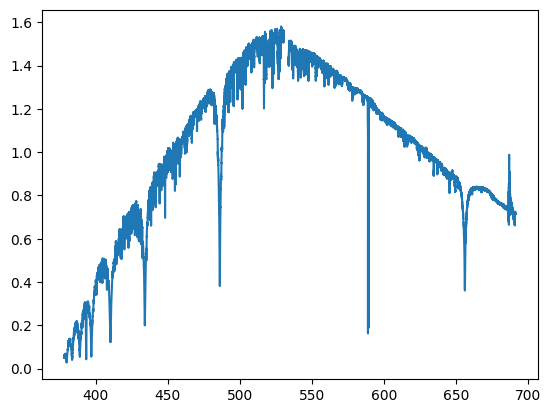

In [7]:
plt.plot(wl, meanspec.flatten())

In [20]:
np.save("HARPS/real/mean_broadened", (wl, meanspec.flatten()))

Continuum-normalising spectra

In [8]:
def limb_darkening(r, Rp_Rs, u1, u2):
    mu = np.sqrt(1 - r**2)
    mask = -1 * (np.floor(r) - 1)
    D = (
        Rp_Rs**2
        * ((1 - u1 * (1 - mu) - u2 * (1 - mu) ** 2))
        / (1 - u1 / 3 - u2 / 6)
        * mask
    )
    return 1 - D

In [9]:
r2 = np.sqrt(xp2**2 + yp2**2)
r1 = np.sqrt(xp1**2 + yp1**2)
r3 = np.sqrt(xp3**2 + yp3**2)

In [10]:
LD2 = limb_darkening(r2, RpRs, u1, u2)[:, np.newaxis]
LD2[np.isnan(LD2)] = 1
flux_LD2 = flux2 / np.nanmean(flux2, axis=1)[:, np.newaxis] * LD2

LD1 = limb_darkening(r1, RpRs, u1, u2)[:, np.newaxis]
LD1[np.isnan(LD1)] = 1
flux_LD1 = flux1 / np.nanmean(flux1, axis=1)[:, np.newaxis] * LD1

LD3 = limb_darkening(r3, RpRs, u1, u2)[:, np.newaxis]
LD3[np.isnan(LD3)] = 1
flux_LD3 = flux3 / np.nanmean(flux3, axis=1)[:, np.newaxis] * LD3

/tmp/ipykernel_3858408/190764633.py:2: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


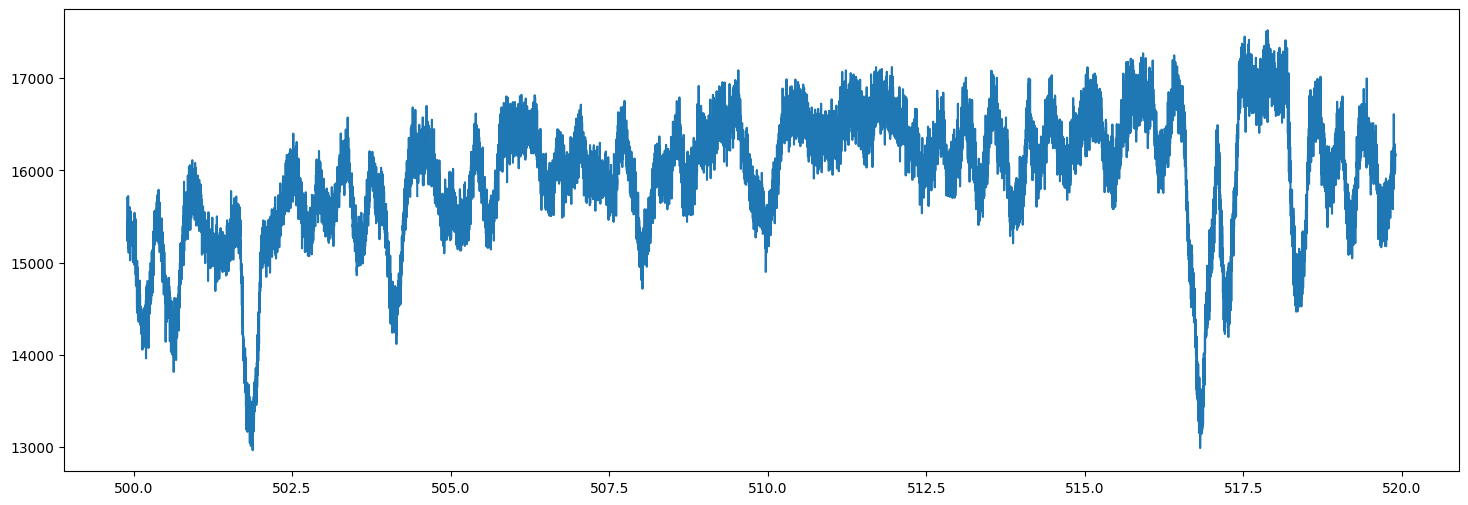

In [17]:
Mg_line_mask = (wl2 > 500) & (wl2 < 520)
wl_Fe = ops.vactoair(wl2[Mg_line_mask]) * doppler_shift1
flux_Fe2 = flux2[:, Mg_line_mask]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])
# plt.xlim(400, 408)

In [11]:
FstarN2 = narrow_spectrum.compute_FstarN(
    ops.vactoair(wl2) * doppler_shift1,
    flux_LD2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

FstarN1 = narrow_spectrum.compute_FstarN(
    ops.vactoair(wl1) * doppler_shift1,
    flux_LD1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

FstarN3 = narrow_spectrum.compute_FstarN(
    ops.vactoair(wl3) * doppler_shift1,
    flux_LD3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

/home/madeline/masters-project/narrow_spectrum.py:140: RuntimeWarning: Mean of empty slice
  F_oot = np.nanmean(F[out_of_transit_idx],axis=0).flatten()
/home/madeline/masters-project/narrow_spectrum.py:9: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)
/home/madeline/masters-project/narrow_spectrum.py:89: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


In [12]:
wl = ops.vactoair(wl2) * doppler_shift1

FstarN1_interp = interp1d(
    ops.vactoair(wl1) * doppler_shift1, FstarN1, bounds_error=False
)(wl)
FstarN3_interp = interp1d(
    ops.vactoair(wl3) * doppler_shift1, FstarN3, bounds_error=False
)(wl)

In [18]:
SN_order55_night1 = 25
SN_order55_night2 = 25
SN_order55_night3 = 32

(0.0, 2.0)

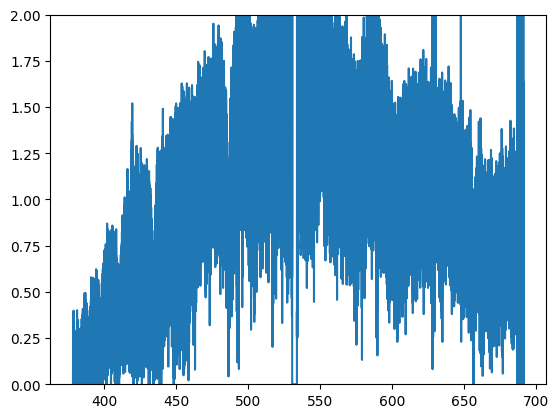

In [20]:
mean_FstarN = np.nansum(
    (
        FstarN1_interp * SN_order55_night1**2,
        FstarN2 * SN_order55_night2**2,
        FstarN3_interp * SN_order55_night3**2,
    ),
    axis=0,
) / np.nansum((SN_order55_night1**2, SN_order55_night2**2, SN_order55_night3**2))
plt.plot(wl, mean_FstarN)
# plt.plot(wl,FstarN1_interp)
# plt.plot(wl,FstarN2)
# plt.plot(wl,FstarN3_interp)
# plt.plot(wl, flux_LD2[0])
# plt.xlim(500, 501)
plt.ylim(0, 2)
# plt.ylim(-10000,10000)
# plt.plot(wl2,np.nanmean(flux2[out_of_transit_idx2],axis=0).flatten())

In [21]:
data_wl = wl
data_flux = mean_FstarN
data = np.vstack((data_wl, data_flux))
np.save("HARPS/real/mean_narrow.npy", data)

In [133]:
start = [
    4000,
    4500,
    5000,
    5200,
    5350,
    5500,
    6000,
]

end = [
    4500,
    5000,
    5200,
    5300,
    5500,
    6000,
    6500,
]

In [135]:
cont_mask = (wl2 > start) & (wl2 < end)
wl2[cont_mask]

ValueError: operands could not be broadcast together with shapes (313103,) (7,) 

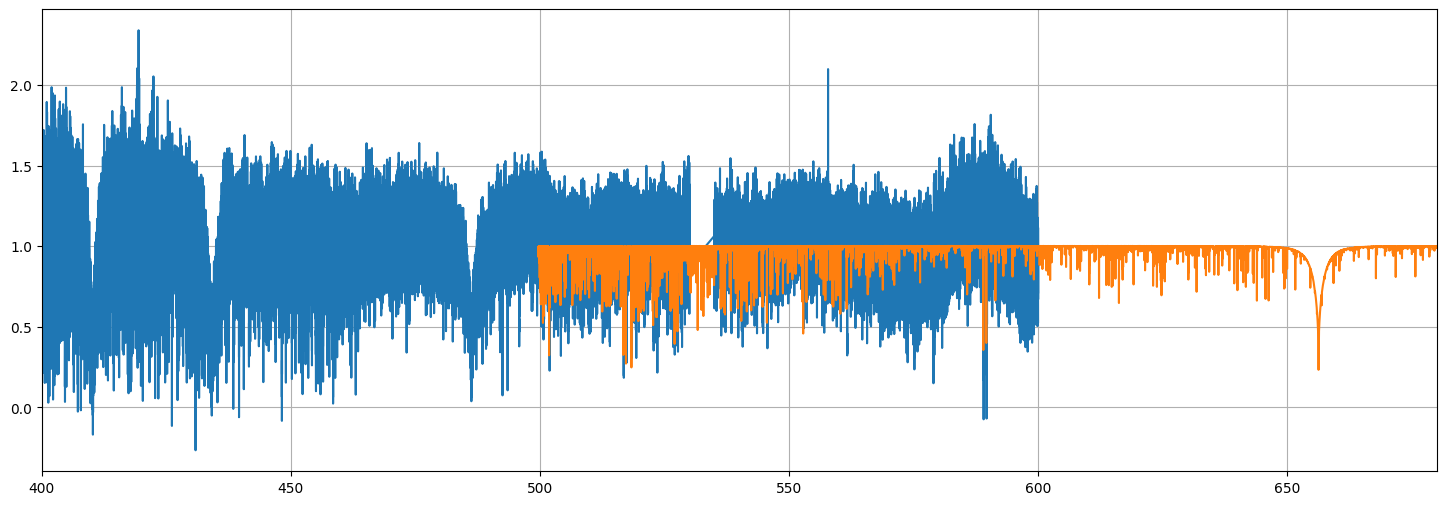

In [134]:
snr = np.load("HARPS_snr_3transits.npy")
wl_segments = []
flux_segments = []
snr_segments = []

for segment in range(len(start) - 1):
    wl_crop = wl2[(wl2 > start[segment] / 10) & (wl2 < end[segment] / 10)]
    flux_crop = mean_FstarN[(wl2 > start[segment] / 10) & (wl2 < end[segment] / 10)]
    flux_crop[np.isnan(flux_crop)] = 1
    fit = np.polyfit(wl_crop, flux_crop, 1)
    p = np.poly1d(fit)
    FstarN1_norm = flux_crop / p(wl_crop)
    wl_segments.append(wl_crop)
    flux_segments.append(FstarN1_norm)
    # snr_segments.append(snr[(wl2 > start[segment] / 10) & (wl2 < end[segment] / 10)])

meanspec = np.concatenate(flux_segments)
# snr_segments = np.concatenate(snr_segments)

plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe, F_oot)
# plt.plot(wl_Fe, p(wl_Fe))
plt.plot(np.concatenate(wl_segments), meanspec)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(400, 680)
# plt.ylim(0, 1.5)
plt.grid()

In [14]:
Mg_line_mask = (wl1 > 400) & (wl1 < 408)
wl_Fe1 = ops.vactoair(wl1[Mg_line_mask]) * doppler_shift1
flux_Fe1 = flux1[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe1[out_of_transit_idx1]), axis=0).flatten()
Fe_cont_mask = ((wl_Fe1 > 401.9) & (wl_Fe1 < 402.1)) | (
    (wl_Fe1 > 404.7) & (wl_Fe1 < 404.8)
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1)) - 0.05

FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)
FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [15]:
Mg_line_mask = (wl3 > 400) & (wl3 < 408)
wl_Fe3 = ops.vactoair(wl3[Mg_line_mask]) * doppler_shift1
flux_Fe3 = flux3[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe3[out_of_transit_idx3]), axis=0).flatten()
Fe_cont_mask = ((wl_Fe3 > 401.9) & (wl_Fe3 < 402.1)) | (
    (wl_Fe3 > 404.7) & (wl_Fe3 < 404.8)
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3)) - 0.05

FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(404.0002287205199, 405.99934363249133)

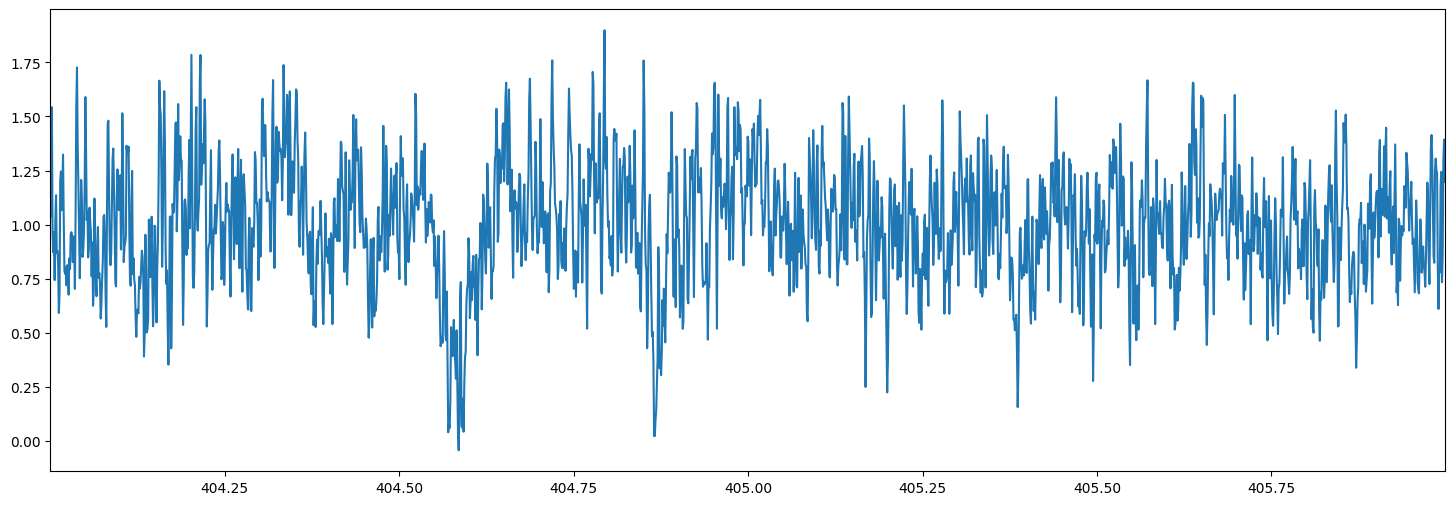

In [24]:
wl_mask = (wl_Fe > 404) & (wl_Fe < 406)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]
mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask)
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))
# plt.xlim(478, 660)

In [22]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)  # Selecting region 1

Section

(414.0, 425.0)

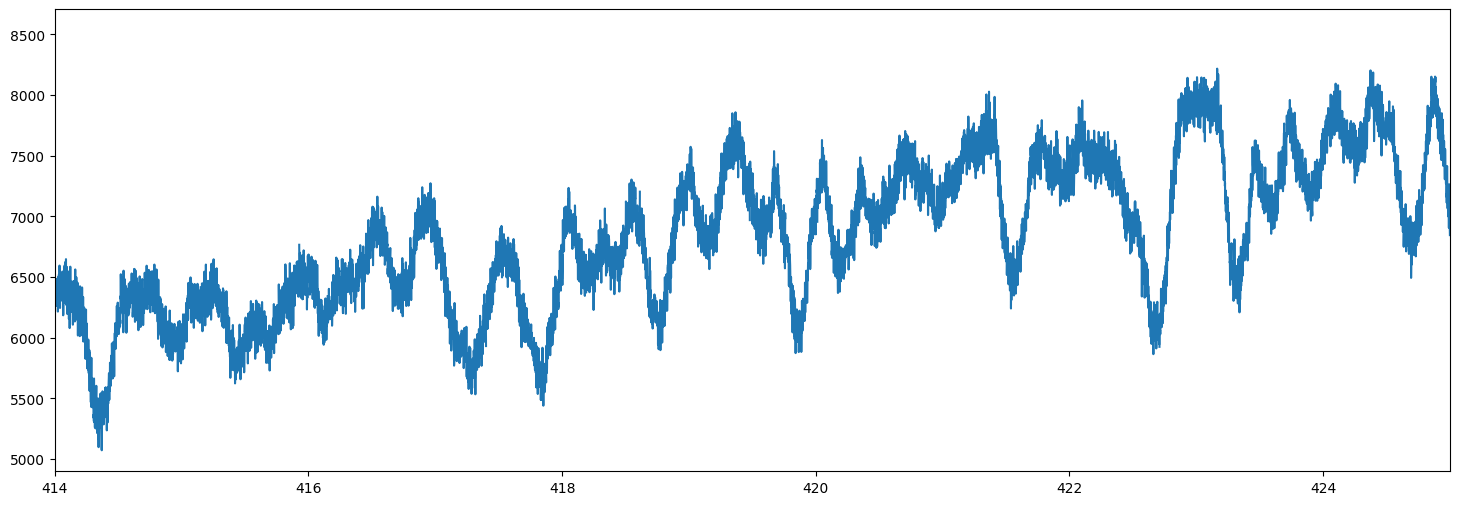

In [25]:
Mg_line_mask = (wl2 > 414) & (wl2 < 426)
wl_Fe = ops.vactoair(wl2[Mg_line_mask]) * doppler_shift1
flux_Fe2 = flux2[:, Mg_line_mask]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])
plt.xlim(414, 425)

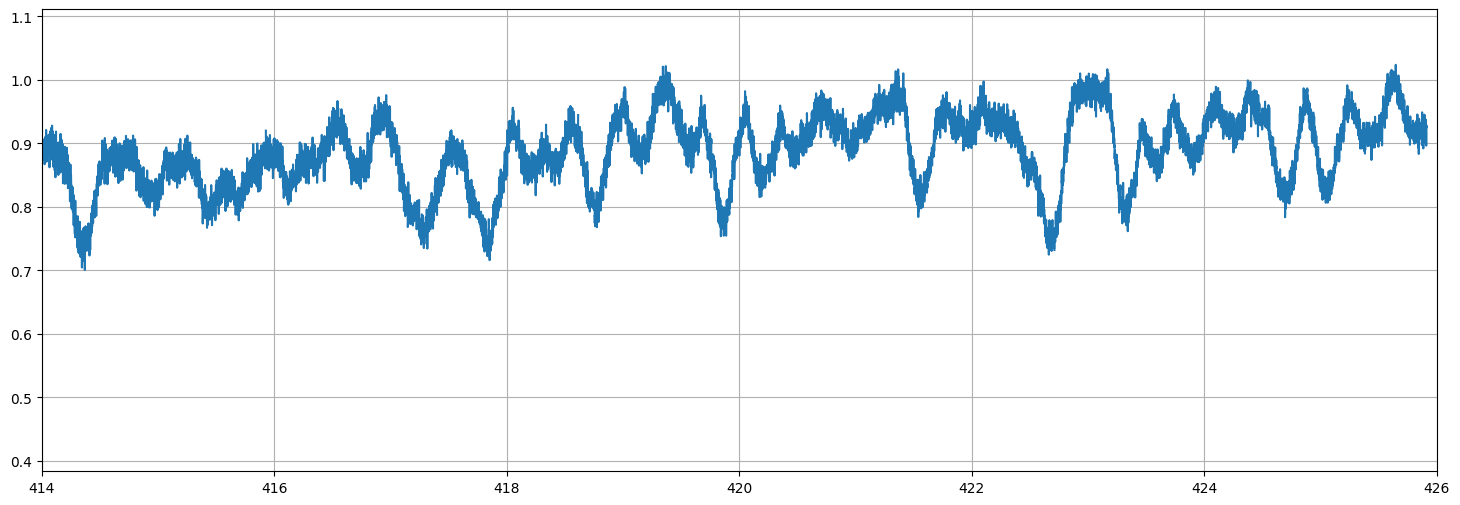

In [27]:
F_oot = np.nanmean((flux_Fe2[out_of_transit_idx2]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe > 419.3) & (wl_Fe < 419.4))
    | ((wl_Fe > 422.85) & (wl_Fe < 423.2))
    | ((wl_Fe > 425.55) & (wl_Fe < 425.7))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe)) - 0.02

plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe, F_oot)
# plt.plot(wl_Fe, p(wl_Fe))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(414, 426)
# plt.ylim(0.8,1.1)
plt.grid()

In [28]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [29]:
Mg_line_mask = (wl1 > 414) & (wl1 < 426)
wl_Fe1 = ops.vactoair(wl1[Mg_line_mask]) * doppler_shift1
flux_Fe1 = flux1[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe1[out_of_transit_idx1]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe1 > 419.3) & (wl_Fe1 < 419.4))
    | ((wl_Fe1 > 422.85) & (wl_Fe1 < 423.2))
    | ((wl_Fe1 > 425.55) & (wl_Fe1 < 425.7))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1)) - 0.02

FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)
FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [30]:
Mg_line_mask = (wl3 > 414) & (wl3 < 426)
wl_Fe3 = ops.vactoair(wl3[Mg_line_mask]) * doppler_shift1
flux_Fe3 = flux3[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe3[out_of_transit_idx3]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe3 > 419.3) & (wl_Fe3 < 419.4))
    | ((wl_Fe3 > 422.85) & (wl_Fe3 < 423.2))
    | ((wl_Fe3 > 425.55) & (wl_Fe3 < 425.7))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3)) - 0.02

FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(420.00014843142696, 424.9994358074884)

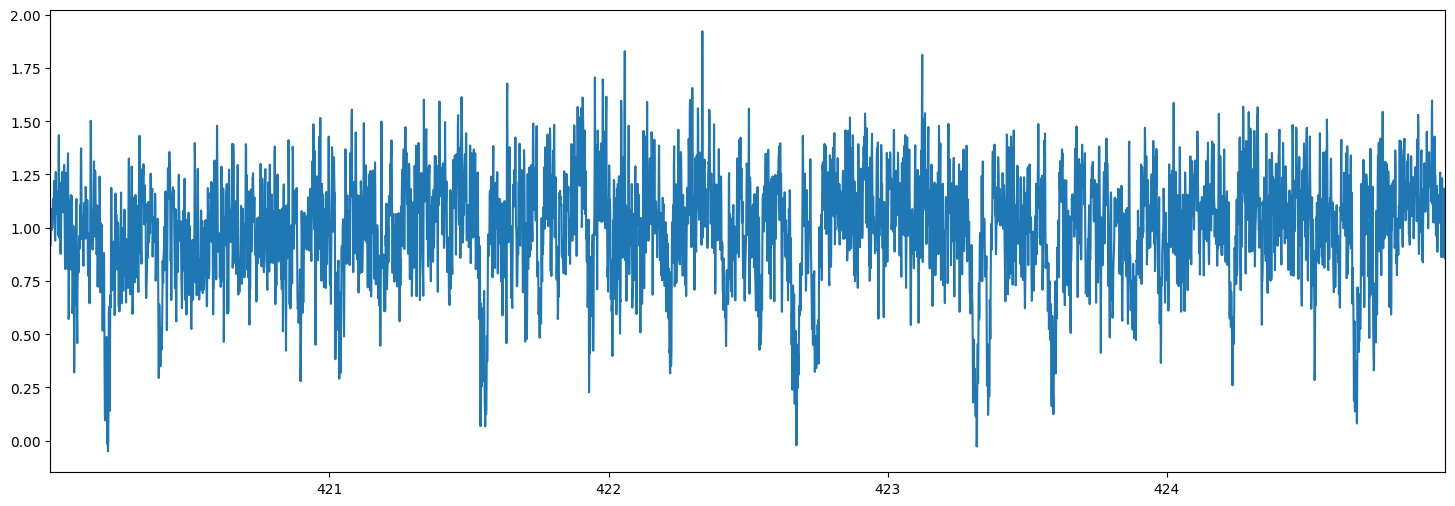

In [35]:
wl_mask = (wl_Fe > 420) & (wl_Fe < 425)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]
mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask)
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))
# plt.xlim(478, 660)

In [36]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)  # Selecting region 1

Section

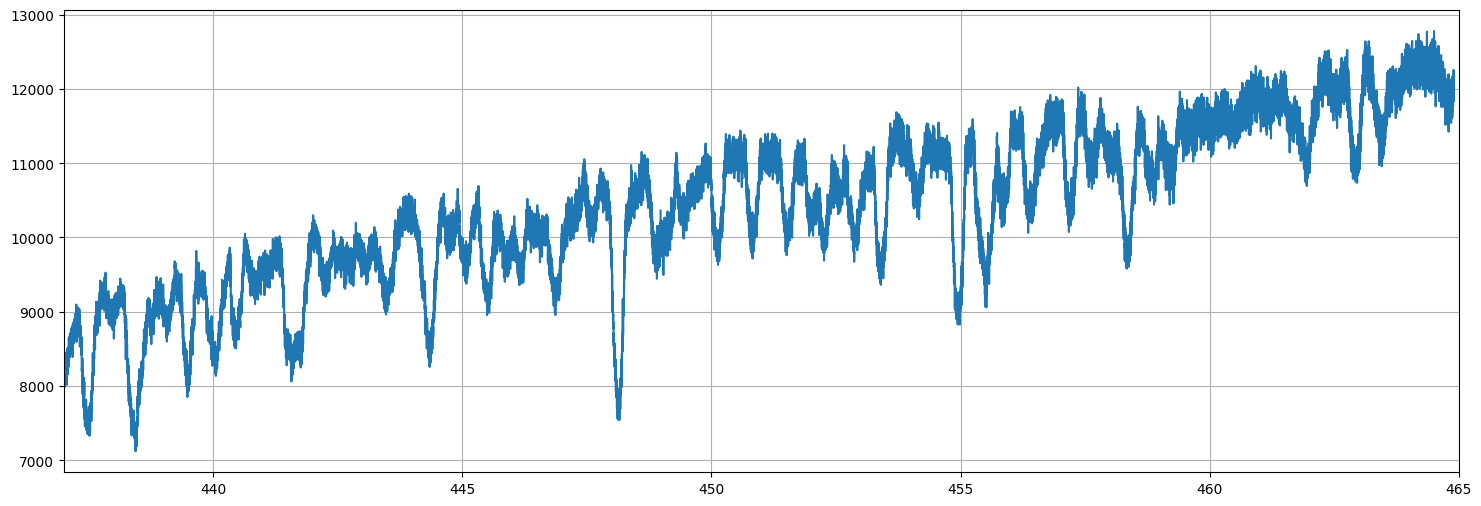

In [37]:
Mg_line_mask = (wl2 > 437) & (wl2 < 465)
wl_Fe = ops.vactoair(wl2[Mg_line_mask]) * doppler_shift1
flux_Fe2 = flux2[:, Mg_line_mask]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])
plt.xlim(437, 465)
plt.grid()

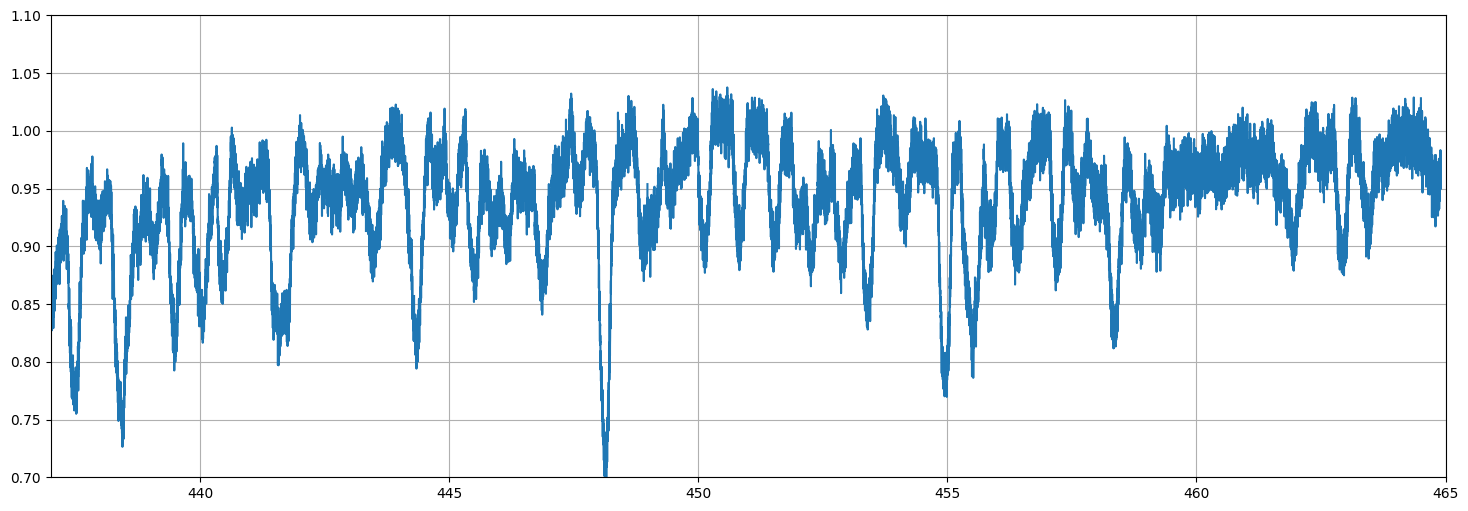

In [39]:
F_oot = np.nanmean((flux_Fe2[out_of_transit_idx2]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe > 447.4) & (wl_Fe < 447.5))
    | ((wl_Fe > 447.8) & (wl_Fe < 447.9))
    | ((wl_Fe > 450.4) & (wl_Fe < 450.6))
    | ((wl_Fe > 453.7) & (wl_Fe < 453.8))
    | ((wl_Fe > 463.1) & (wl_Fe < 463.2))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe))

plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe, F_oot)
# plt.plot(wl_Fe, p(wl_Fe))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(437, 465)
plt.ylim(0.7, 1.1)
plt.grid()

In [40]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [41]:
Mg_line_mask = (wl1 > 437) & (wl1 < 465)
wl_Fe1 = ops.vactoair(wl1[Mg_line_mask]) * doppler_shift1
flux_Fe1 = flux1[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe1[out_of_transit_idx1]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe1 > 447.4) & (wl_Fe1 < 447.5))
    | ((wl_Fe1 > 447.8) & (wl_Fe1 < 447.9))
    | ((wl_Fe1 > 450.4) & (wl_Fe1 < 450.6))
    | ((wl_Fe1 > 453.7) & (wl_Fe1 < 453.8))
    | ((wl_Fe1 > 463.1) & (wl_Fe1 < 463.2))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1))

In [42]:
FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [43]:
Mg_line_mask = (wl3 > 437) & (wl3 < 465)
wl_Fe3 = ops.vactoair(wl3[Mg_line_mask]) * doppler_shift1
flux_Fe3 = flux3[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe3[out_of_transit_idx3]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe3 > 447.4) & (wl_Fe3 < 447.5))
    | ((wl_Fe3 > 447.8) & (wl_Fe3 < 447.9))
    | ((wl_Fe3 > 450.4) & (wl_Fe3 < 450.6))
    | ((wl_Fe3 > 453.7) & (wl_Fe3 < 453.8))
    | ((wl_Fe3 > 463.1) & (wl_Fe3 < 463.2))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3))

FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(457.0002753879686, 458.9993903112735)

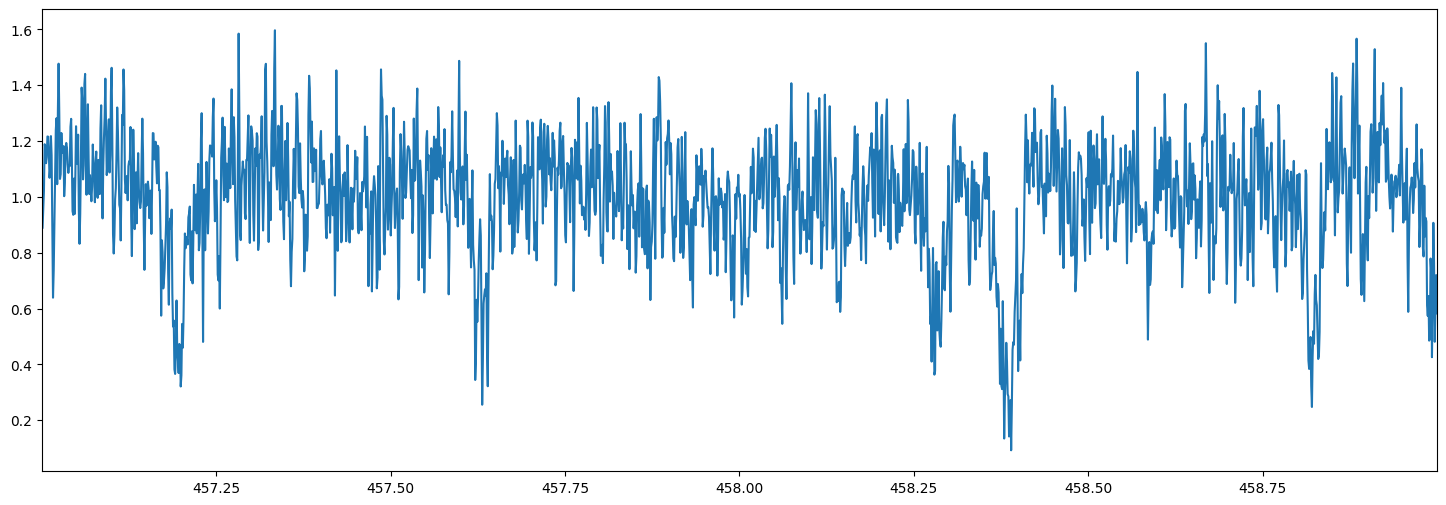

In [48]:
wl_mask = (wl_Fe > 457) & (wl_Fe < 459)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]
mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask)
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))
# plt.xlim(478, 660)

In [49]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)  # Selecting region 1

Section

(478.0, 480.0)

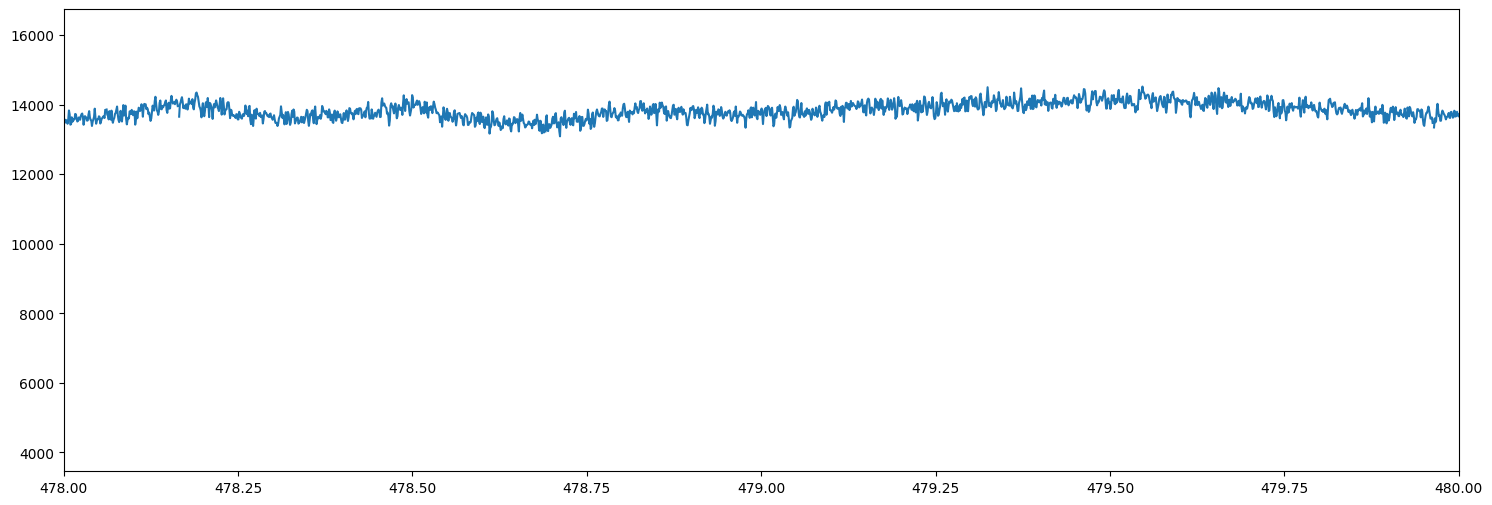

In [50]:
Mg_line_mask = (wl2 > 478) & (wl2 < 500)
wl_Fe = ops.vactoair(wl2[Mg_line_mask]) * doppler_shift1
flux_Fe2 = flux2[:, Mg_line_mask]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])
plt.xlim(478, 480)

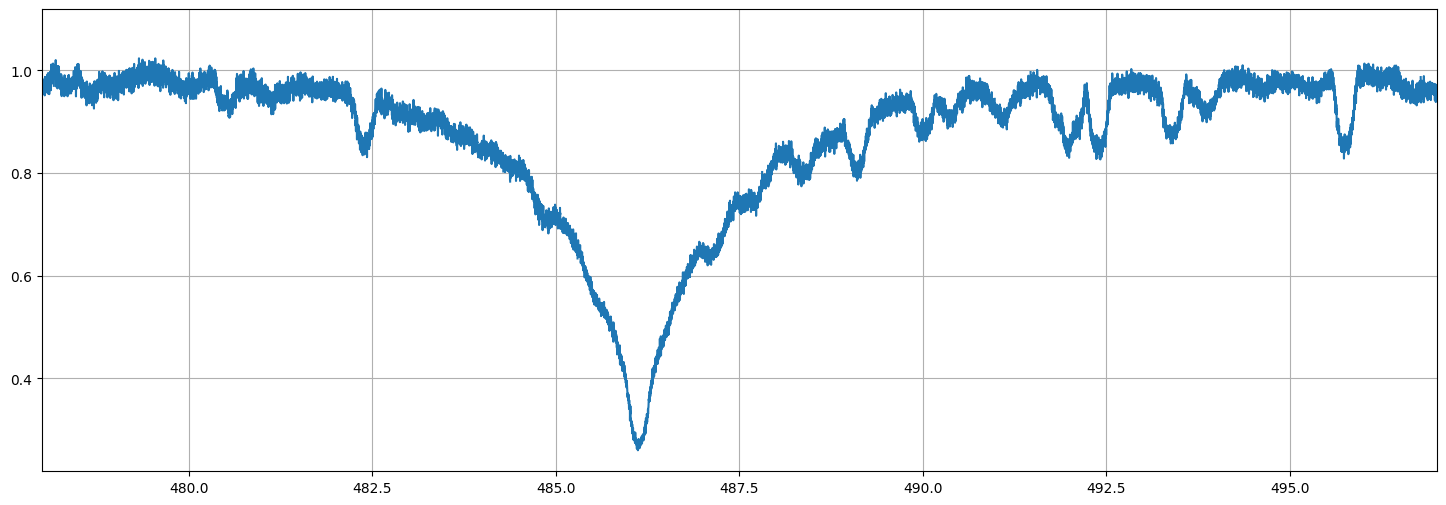

In [51]:
F_oot = np.nanmean((flux_Fe2[out_of_transit_idx2]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe > 478.4) & (wl_Fe < 478.5))
    | ((wl_Fe > 497.9) & (wl_Fe < 496.4))
    | ((wl_Fe > 495.5) & (wl_Fe < 495.6))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe)) - 0.02

plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe, F_oot)
# plt.plot(wl_Fe, p(wl_Fe))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(478, 497)
# plt.ylim(0.8,1.1)
plt.grid()

In [52]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [53]:
Mg_line_mask = (wl1 > 478) & (wl1 < 500)
wl_Fe1 = ops.vactoair(wl1[Mg_line_mask]) * doppler_shift1
flux_Fe1 = flux1[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe1[out_of_transit_idx1]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe1 > 478.4) & (wl_Fe1 < 478.5))
    | ((wl_Fe1 > 497.9) & (wl_Fe1 < 496.4))
    | ((wl_Fe1 > 495.5) & (wl_Fe1 < 495.6))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1)) - 0.02

FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [54]:
Mg_line_mask = (wl3 > 478) & (wl3 < 500)
wl_Fe3 = ops.vactoair(wl3[Mg_line_mask]) * doppler_shift1
flux_Fe3 = flux3[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe3[out_of_transit_idx3]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe3 > 478.4) & (wl_Fe3 < 478.5))
    | ((wl_Fe3 > 497.9) & (wl_Fe3 < 496.4))
    | ((wl_Fe3 > 495.5) & (wl_Fe3 < 495.6))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3)) - 0.02

FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(498.0006324490334, 499.7997358803827)

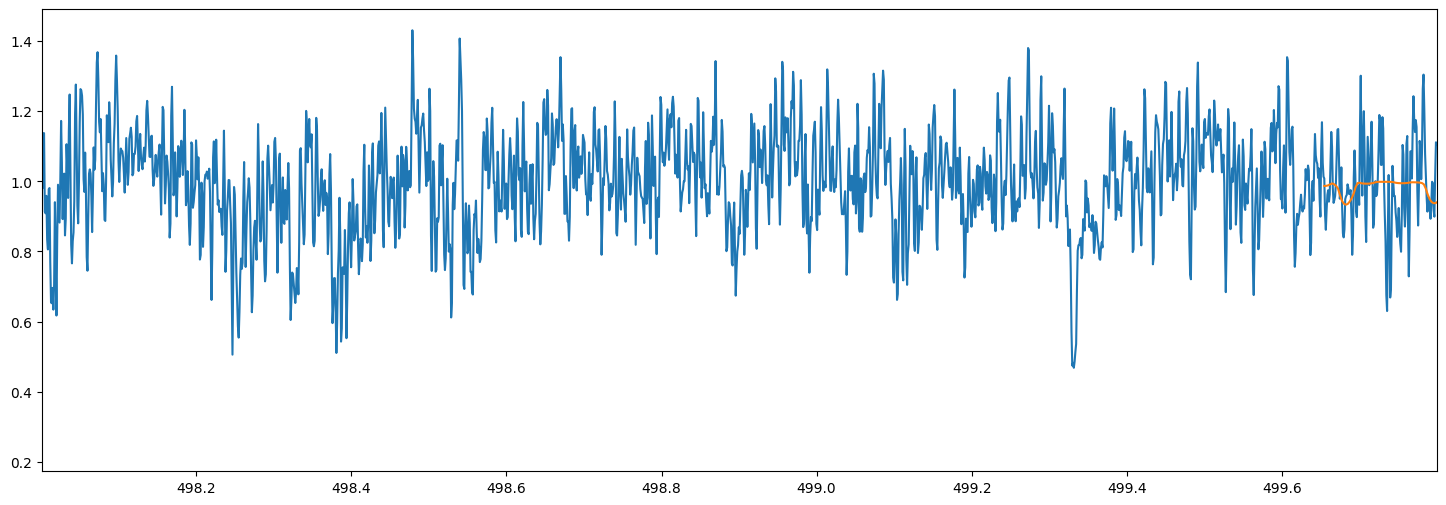

In [58]:
wl_mask = (wl_Fe > 498) & (wl_Fe < 499.8)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]
mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask)
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))
# plt.xlim(478, 660)

In [59]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)  # Selecting region 1

Next region

(500.0, 503.0)

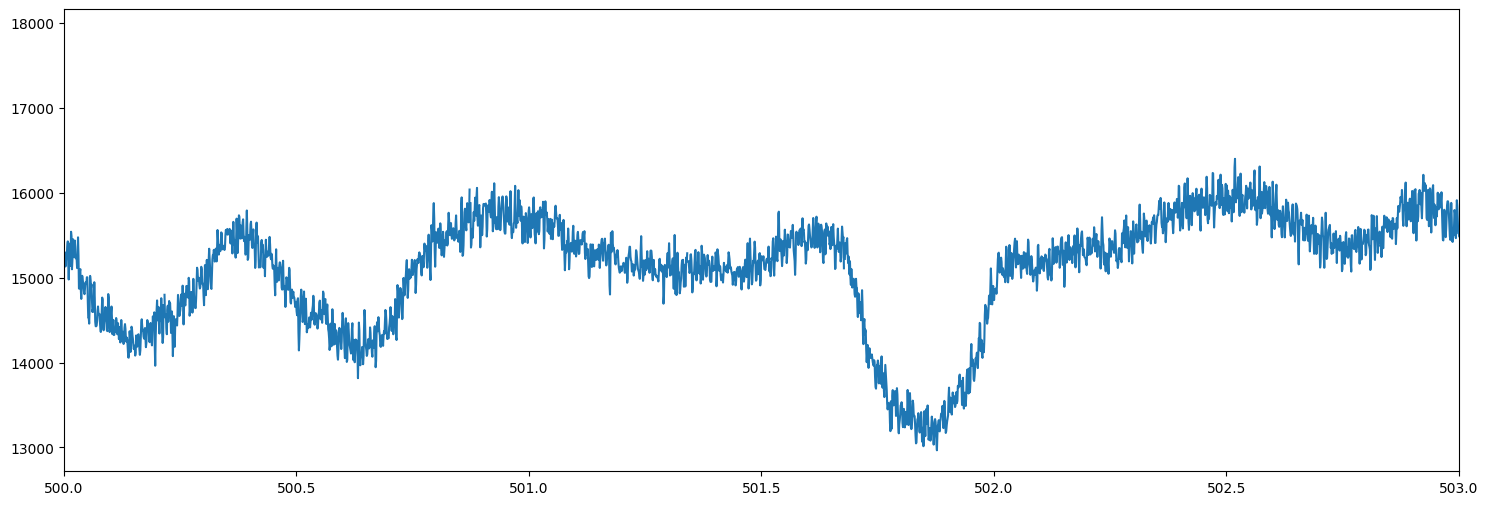

In [60]:
Fe_line_mask = (wl2 < 530) & (wl2 > 500)
wl_Fe = ops.vactoair(wl2[Fe_line_mask]) * doppler_shift1
flux_Fe2 = flux2[:, Fe_line_mask]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])
plt.xlim(500, 503)

In [61]:
Fe_cont_mask = (
    ((wl_Fe > 510.3) & (wl_Fe < 510.35))
    | ((wl_Fe > 515.75) & (wl_Fe < 515.77))
    | ((wl_Fe > 522) & (wl_Fe < 522.5))
    | ((wl_Fe > 504.6) & (wl_Fe < 504.7))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe)) - 0.01

F_oot2 = np.nanmean((flux_Fe_norm2[out_of_transit_idx2]), axis=0).flatten()
# flux_Fe_norm2 /= np.nanmax(F_oot2)

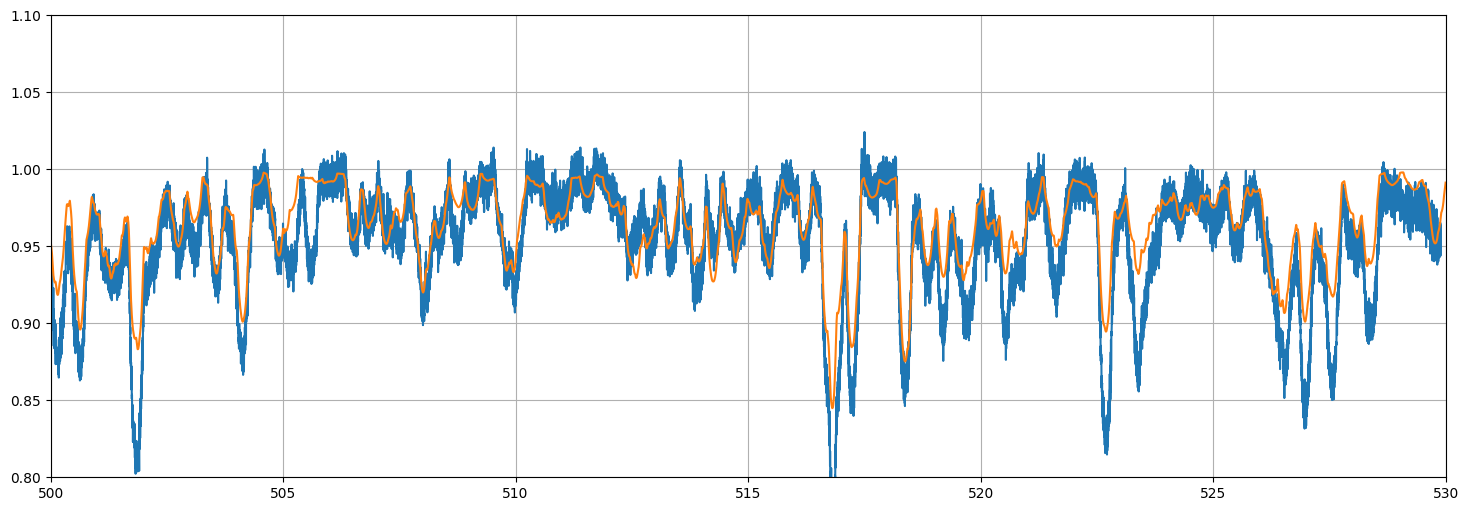

In [62]:
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe_norm2[50])
plt.plot(wl_model, flux_model)
plt.xlim(500, 530)
plt.ylim(0.8, 1.1)
plt.grid()

Calculate $F_{\star,N}$

In [63]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

/home/madeline/masters-project/narrow_spectrum.py:9: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)
/home/madeline/masters-project/narrow_spectrum.py:89: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


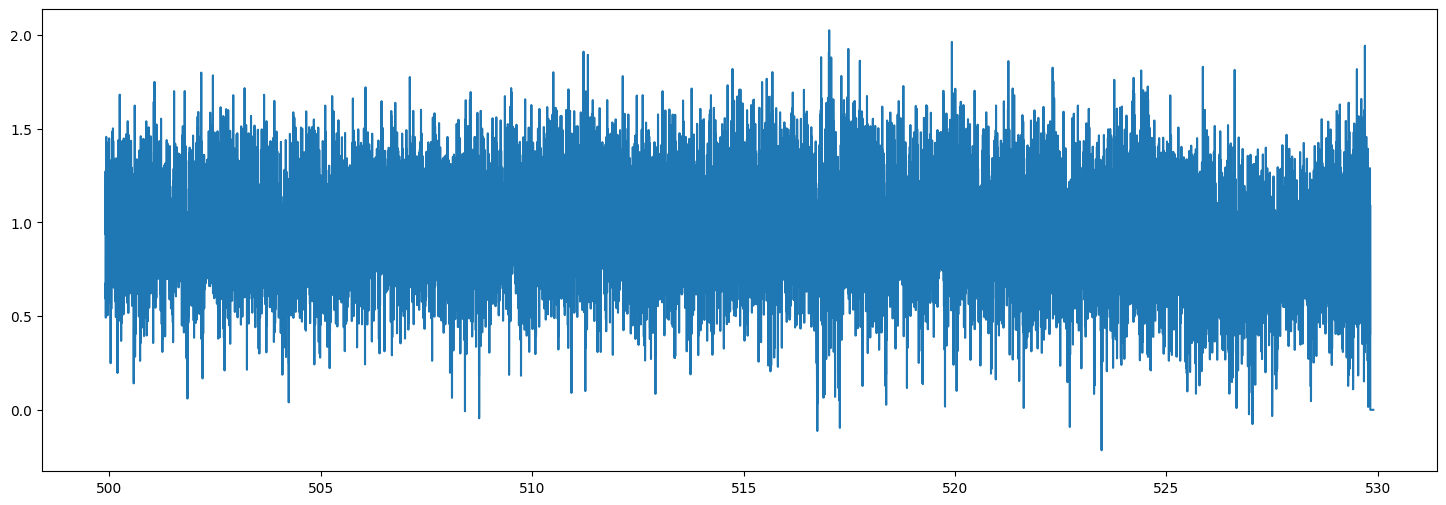

In [64]:
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, FstarN2)

/tmp/ipykernel_3304599/697058151.py:2: RuntimeWarning: Mean of empty slice
  F_oot = np.nanmean(flux1[out_of_transit_idx1], axis=0).flatten()


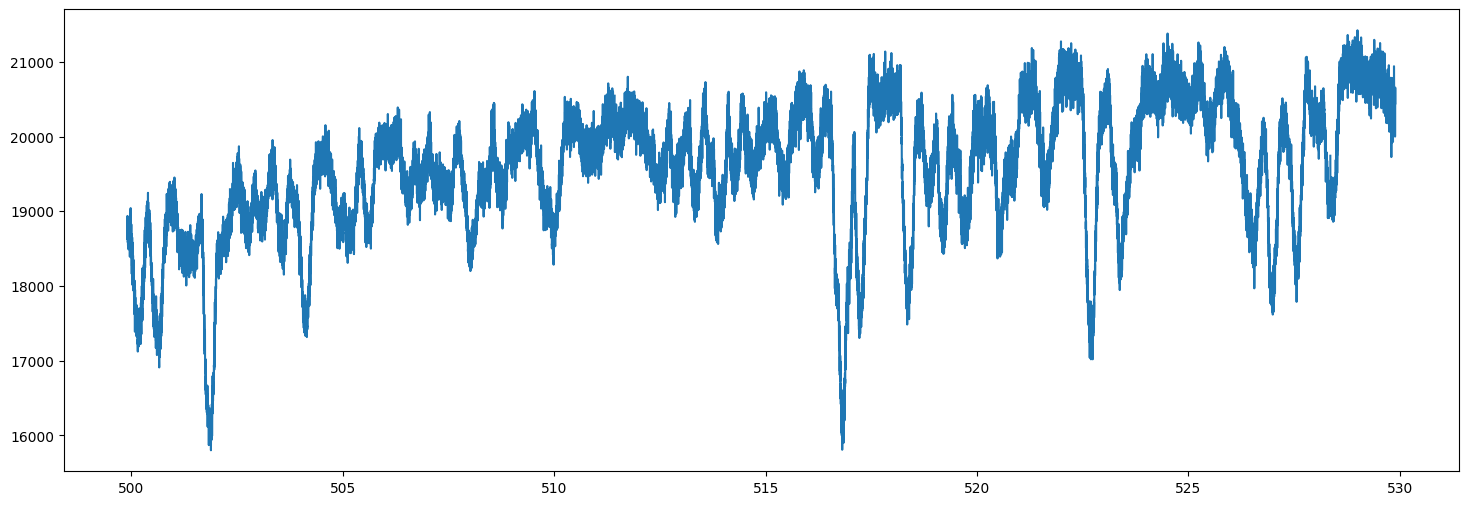

In [65]:
# Selecting region 1
F_oot = np.nanmean(flux1[out_of_transit_idx1], axis=0).flatten()
Fe_line_mask = (wl1 < 530) & (wl1 > 500)
wl_Fe1 = ops.vactoair(wl1[Fe_line_mask]) * doppler_shift1
flux_Fe1 = flux1[:, Fe_line_mask]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe1, flux_Fe1[0])

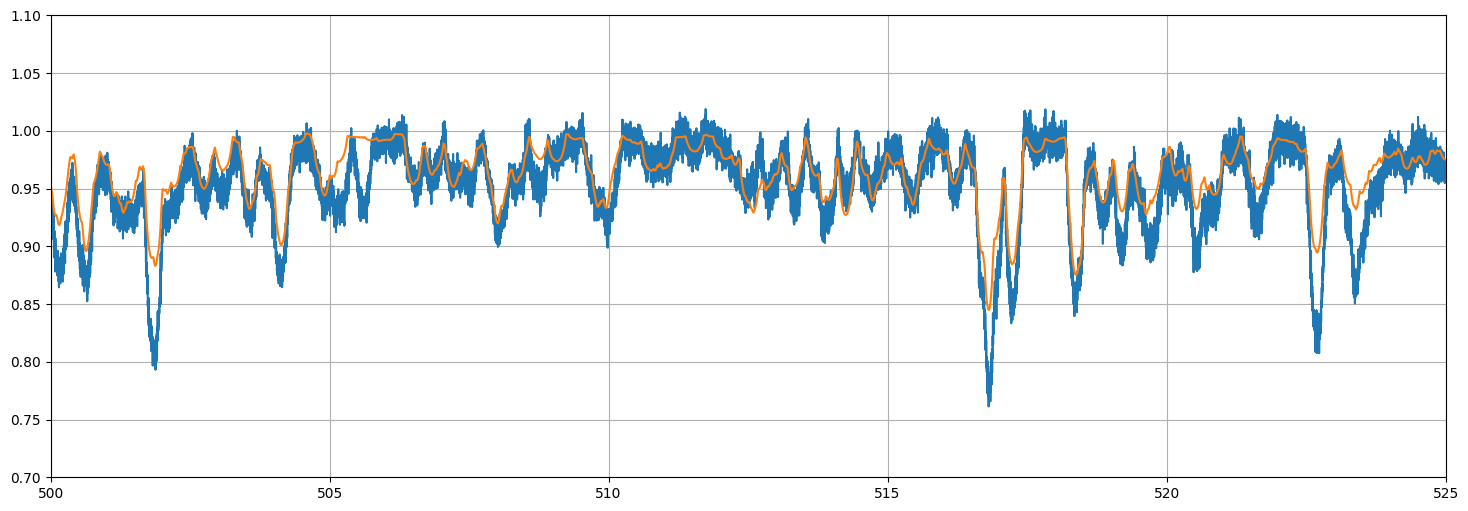

In [66]:
Fe_cont_mask = (
    ((wl_Fe1 > 510.3) & (wl_Fe1 < 510.35))
    | ((wl_Fe1 > 515.75) & (wl_Fe1 < 515.77))
    | ((wl_Fe1 > 522) & (wl_Fe1 < 522.5))
    | ((wl_Fe1 > 504.6) & (wl_Fe1 < 504.7))
    | ((wl_Fe1 > 511.6) & (wl_Fe1 < 511.8))
)


flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1)) - 0.01

F_oot1 = np.nanmean((flux_Fe_norm1[out_of_transit_idx1]), axis=0).flatten()


from scipy.interpolate import interp1d

F_oot1 = interp1d(wl_Fe1, F_oot1, bounds_error=False)(wl_Fe)
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe1, flux_Fe_norm1[0])
plt.plot(wl_model, flux_model)
plt.xlim(500, 525)
plt.ylim(0.7, 1.1)
plt.grid()

In [67]:
FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

from scipy.interpolate import interp1d

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

/tmp/ipykernel_3304599/3078436111.py:2: RuntimeWarning: Mean of empty slice
  F_oot = np.nanmean(flux3[out_of_transit_idx3], axis=0).flatten()


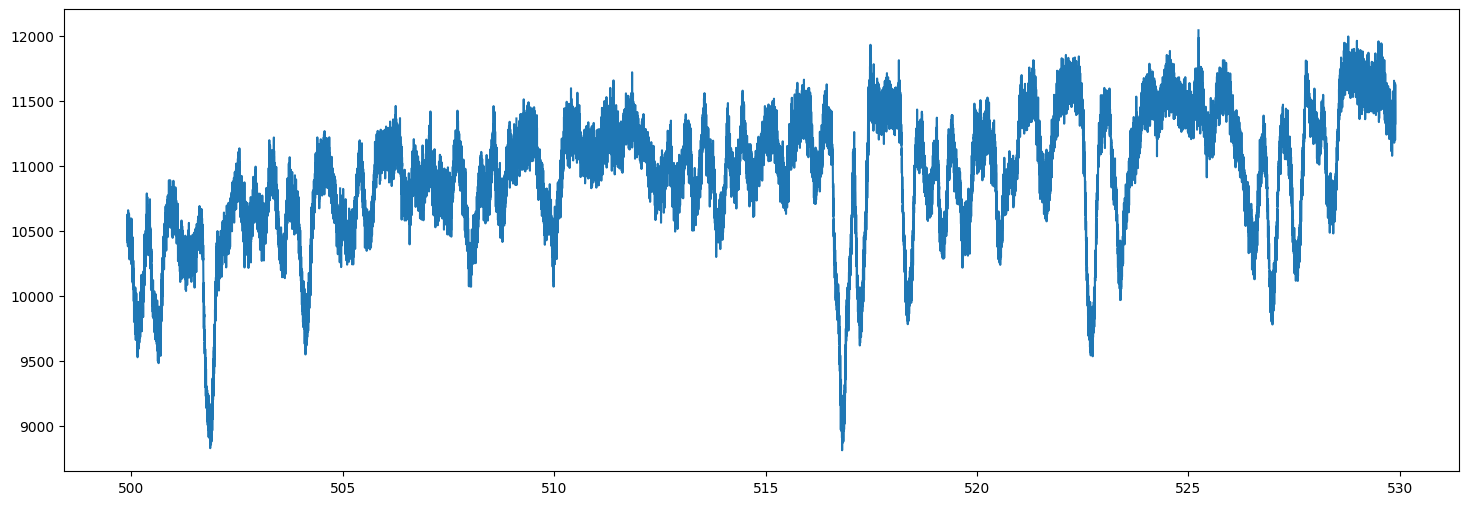

In [68]:
# Selecting region 1
F_oot = np.nanmean(flux3[out_of_transit_idx3], axis=0).flatten()
Fe_line_mask = (wl3 < 530) & (wl3 > 500)
wl_Fe3 = ops.vactoair(wl3[Fe_line_mask]) * doppler_shift1
flux_Fe3 = flux3[:, Fe_line_mask]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe3, flux_Fe3[0])

In [69]:
Fe_cont_mask = (
    ((wl_Fe3 > 510.3) & (wl_Fe3 < 510.35))
    | ((wl_Fe3 > 515.75) & (wl_Fe3 < 515.77))
    | ((wl_Fe3 > 522) & (wl_Fe3 < 522.5))
    | ((wl_Fe3 > 504.6) & (wl_Fe3 < 504.7))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3)) - 0.01

F_oot3 = np.nanmean((flux_Fe_norm3[out_of_transit_idx3]), axis=0).flatten()
F_oot3 = interp1d(wl_Fe3, F_oot3, bounds_error=False)(wl_Fe)

In [70]:
FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

from scipy.interpolate import interp1d

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

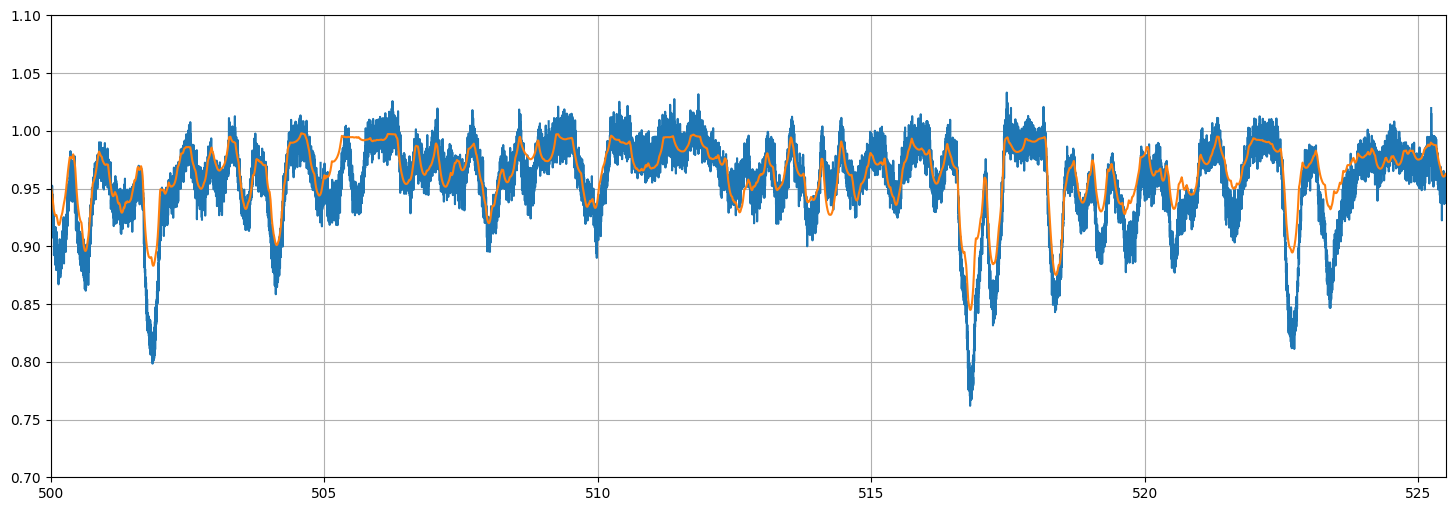

In [71]:
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe3, flux_Fe_norm3[0])
# plt.plot(wl_Fe3,FstarN3)
plt.plot(wl_model, flux_model)
plt.xlim(500, 525.5)
plt.ylim(0.7, 1.1)
plt.grid()

(519.0008397751702, 520.999954708084)

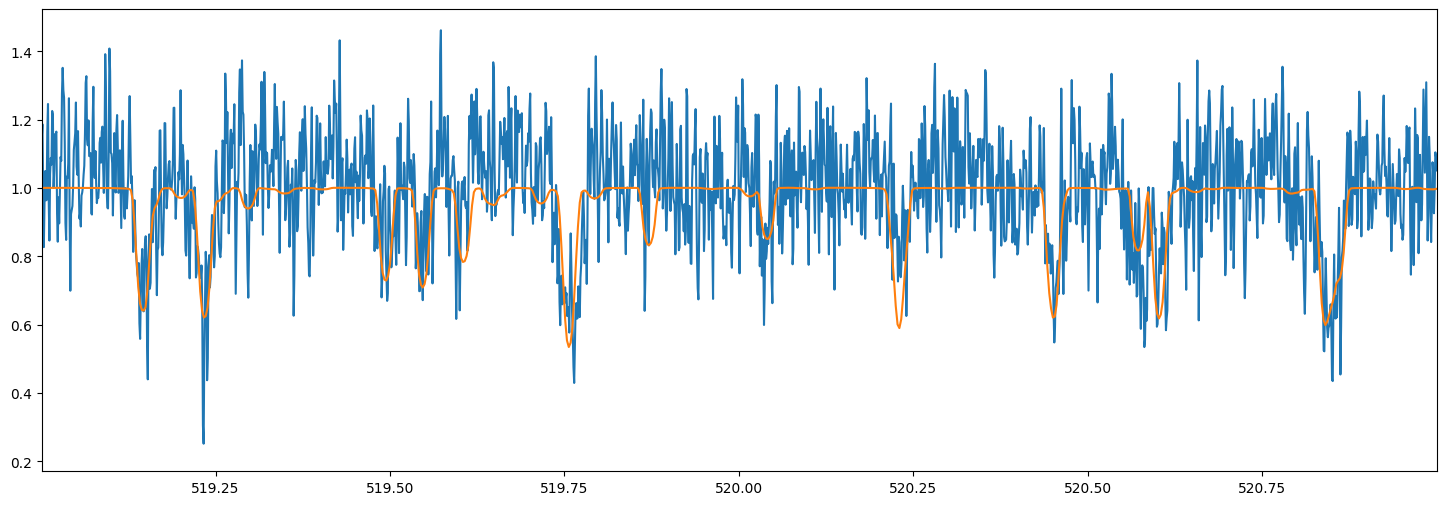

In [78]:
wl_mask = (wl_Fe > 519) & (wl_Fe < 521)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]

mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask)
# plt.plot(wl_Fe[wl_mask],FstarN2_mask)
# plt.plot(wl_Fe[wl_mask],FstarN3_mask)
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))

In [79]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night1.append(FstarN1_mask / np.nanmedian(FstarN1_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night2.append(FstarN2_mask / np.nanmedian(FstarN2_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night3.append(FstarN3_mask / np.nanmedian(FstarN3_mask))

In [51]:
mean_Foot = np.mean(np.vstack((F_oot1, F_oot2, F_oot3)), axis=0)

In [54]:
wl_all_broad.append(wl_Fe)
flux_all_broad.append(mean_Foot)

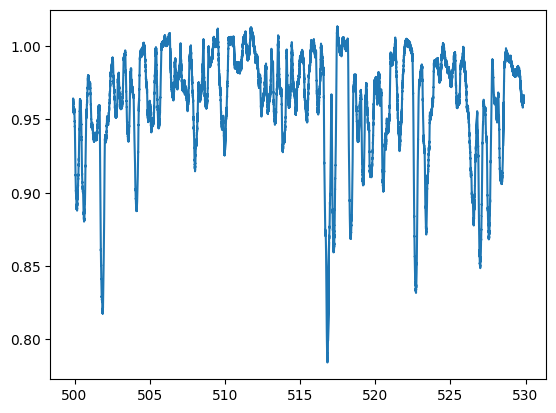

In [52]:
plt.plot(wl_Fe, mean_Foot)

In [53]:
data = np.vstack((wl_Fe, mean_Foot))
np.save("WASP189_HARPS_3nights_broadened1.npy", data)

Segment 2

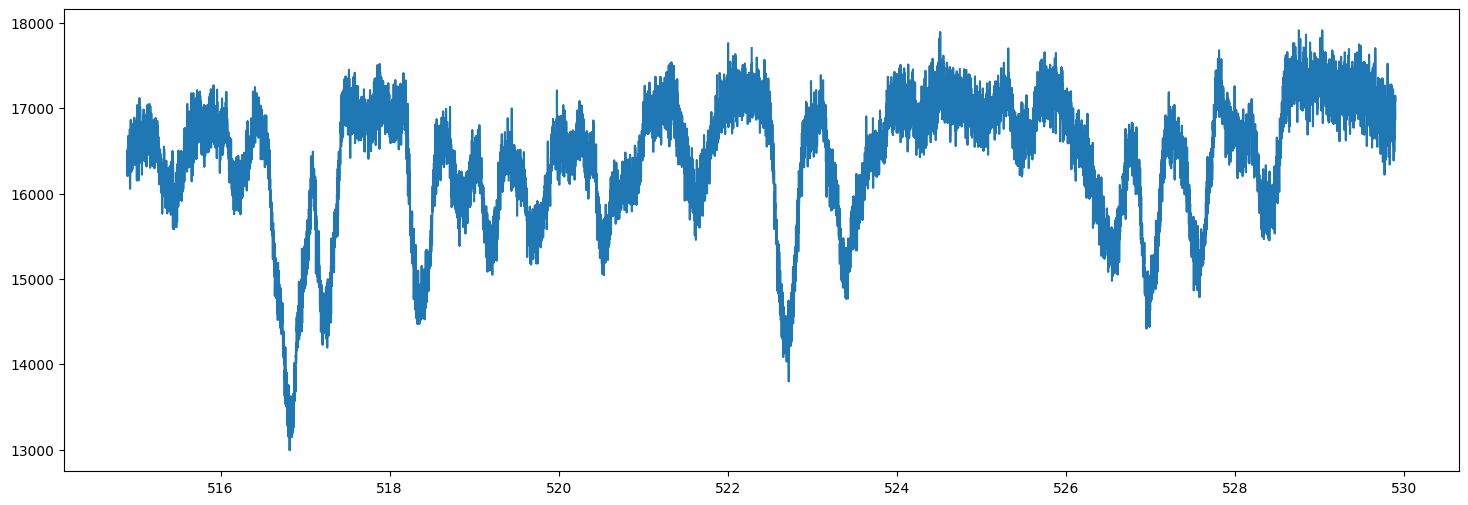

In [80]:
Fe_line_mask2 = (wl2 < 530) & (wl2 > 515)
wl_Fe = ops.vactoair(wl2[Fe_line_mask2]) * doppler_shift1
flux_Fe2 = flux2[:, Fe_line_mask2]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])

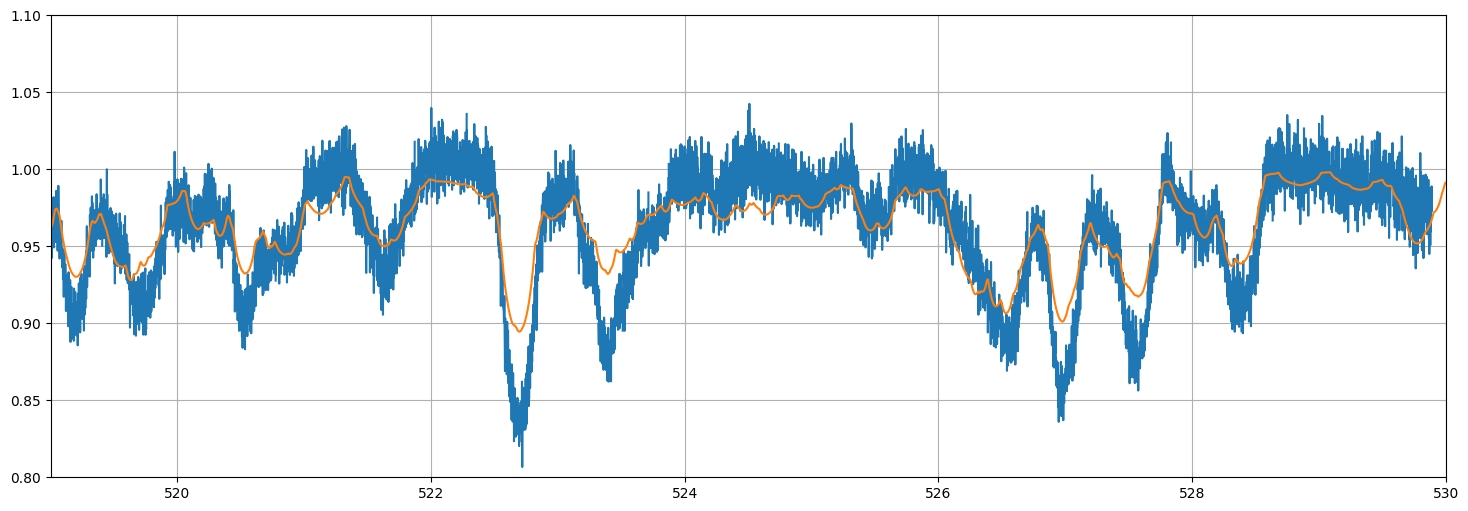

In [81]:
Fe_cont_mask = (
    ((wl_Fe > 521.2) & (wl_Fe < 521.3))
    | ((wl_Fe > 528.6) & (wl_Fe < 528.7))
    | ((wl_Fe > 529) & (wl_Fe < 529.1))
)


flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe))

F_oot2 = np.nanmean((flux_Fe_norm2[out_of_transit_idx2]), axis=0).flatten()
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(519, 530)
plt.ylim(0.8, 1.1)
plt.grid()

In [82]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [83]:
Fe_line_mask2 = (wl1 < 530) & (wl1 > 515)
wl_Fe1 = ops.vactoair(wl1[Fe_line_mask2]) * doppler_shift1
flux_Fe1 = flux1[:, Fe_line_mask2]
F_oot = np.nanmean((flux_Fe1[out_of_transit_idx1]), axis=0).flatten()

Fe_cont_mask = (
    ((wl_Fe1 > 521.2) & (wl_Fe1 < 521.3))
    | ((wl_Fe1 > 528.6) & (wl_Fe1 < 528.7))
    | ((wl_Fe1 > 529) & (wl_Fe1 < 529.1))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1))

F_oot1 = np.nanmean((flux_Fe_norm1[out_of_transit_idx1]), axis=0).flatten()
FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

In [84]:
from scipy.interpolate import interp1d

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)
# mean_FstarN = np.nanmean(
#     np.vstack((FstarN1 / np.nanmedian(FstarN1), FstarN2 / np.nanmedian(FstarN2))),
#     axis=0,
# )

In [85]:
Fe_line_mask2 = (wl3 < 530) & (wl3 > 515)
wl_Fe3 = ops.vactoair(wl3[Fe_line_mask2]) * doppler_shift1
flux_Fe3 = flux3[:, Fe_line_mask2]


Fe_cont_mask = (
    ((wl_Fe3 > 521.2) & (wl_Fe3 < 521.3))
    | ((wl_Fe3 > 528.6) & (wl_Fe3 < 528.7))
    | ((wl_Fe3 > 529) & (wl_Fe3 < 529.1))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3))

F_oot3 = np.nanmean((flux_Fe_norm3[out_of_transit_idx3]), axis=0).flatten()

FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(525.0001846896276, 526.9992996232594)

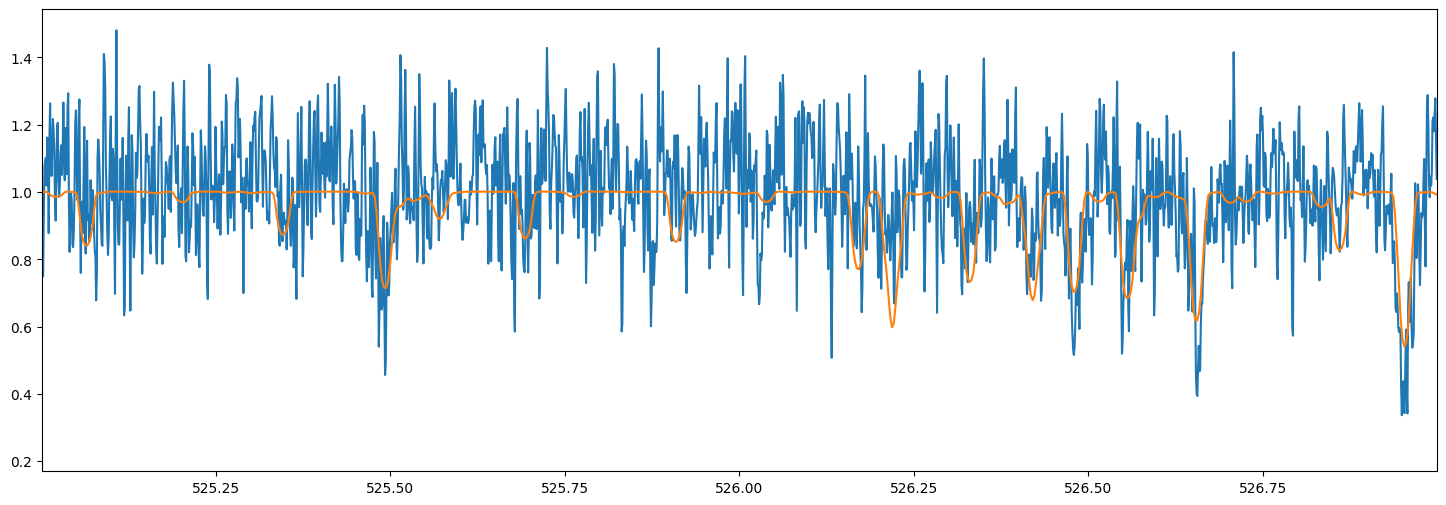

In [90]:
wl_mask = (wl_Fe > 525) & (wl_Fe < 527)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]

mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask)
# plt.plot(wl_Fe[wl_mask],FstarN2_mask)
# plt.plot(wl_Fe[wl_mask],FstarN3_mask)
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
# plt.plot(wl_synth,flux_synth)

plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))

In [91]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night1.append(FstarN1_mask / np.nanmedian(FstarN1_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night2.append(FstarN2_mask / np.nanmedian(FstarN2_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night3.append(FstarN3_mask / np.nanmedian(FstarN3_mask))

In [ ]:
mean_Foot = np.mean(np.vstack((F_oot1, F_oot2, F_oot3)), axis=0)

Segment 3

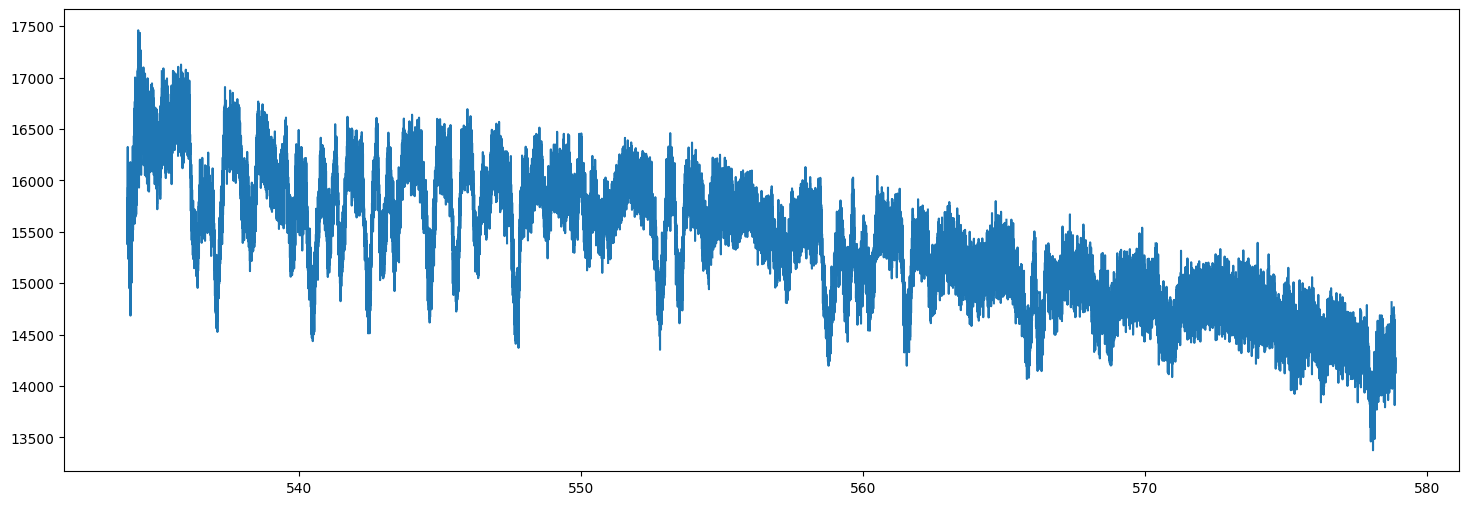

In [92]:
Fe_line_mask3 = (wl2 < 579) & (wl2 > 534)
wl_Fe = ops.vactoair(wl2[Fe_line_mask3]) * doppler_shift1
flux_Fe2 = flux2[:, Fe_line_mask3]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])

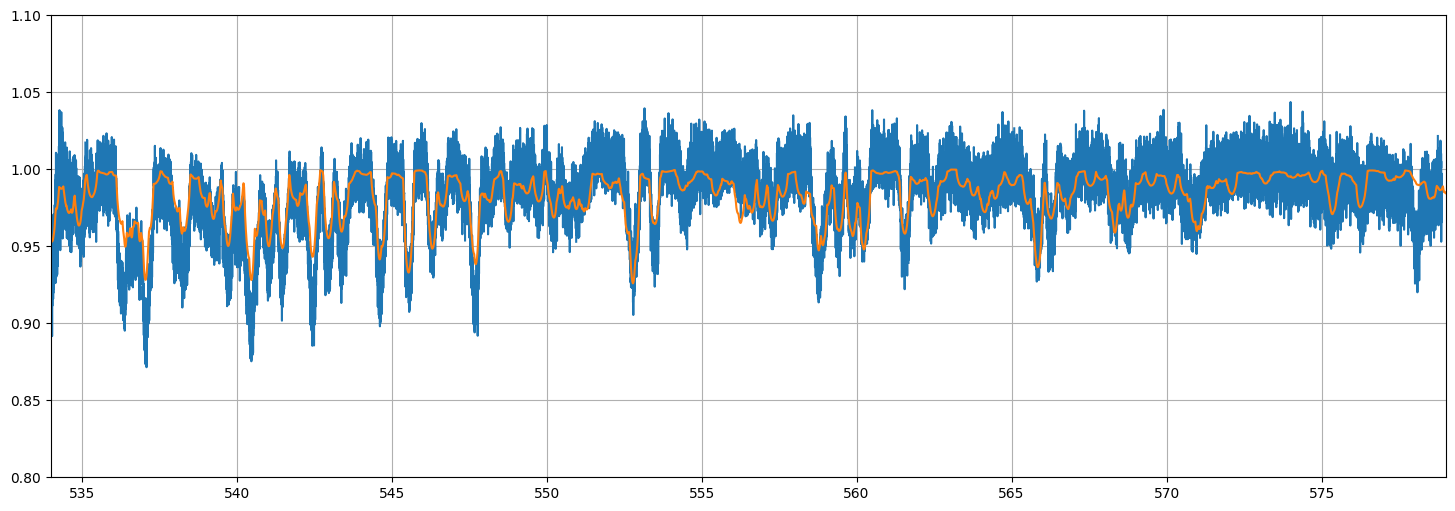

In [93]:
Fe_cont_mask = (
    ((wl_Fe > 560.5) & (wl_Fe < 561.3))
    | ((wl_Fe > 543.7) & (wl_Fe < 544.3))
    | ((wl_Fe > 564.6) & (wl_Fe < 564.8))
    | ((wl_Fe > 569.21) & (wl_Fe < 569.31))
    | ((wl_Fe > 576.5) & (wl_Fe < 577))
    | ((wl_Fe > 577.7) & (wl_Fe < 577.8))
    | ((wl_Fe > 551.5) & (wl_Fe < 551.8))
    | ((wl_Fe > 534.3) & (wl_Fe < 534.45))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe))

F_oot2 = np.nanmean((flux_Fe_norm2[out_of_transit_idx2]), axis=0).flatten()

plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(534, 579)
plt.ylim(0.8, 1.1)
plt.grid()

In [94]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [95]:
Fe_line_mask3 = (wl1 < 579) & (wl1 > 534)
wl_Fe1 = ops.vactoair(wl1[Fe_line_mask3]) * doppler_shift1
flux_Fe1 = flux1[:, Fe_line_mask3]


Fe_cont_mask = (
    ((wl_Fe1 > 560.5) & (wl_Fe1 < 561.3))
    | ((wl_Fe1 > 543.7) & (wl_Fe1 < 544.3))
    | ((wl_Fe1 > 564.6) & (wl_Fe1 < 564.8))
    | ((wl_Fe1 > 569.21) & (wl_Fe1 < 569.31))
    | ((wl_Fe1 > 576.5) & (wl_Fe1 < 577))
    | ((wl_Fe1 > 577.7) & (wl_Fe1 < 577.8))
    | ((wl_Fe1 > 551.5) & (wl_Fe1 < 551.8))
    | ((wl_Fe1 > 534.3) & (wl_Fe1 < 534.45))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1))

F_oot1 = np.nanmean((flux_Fe_norm1[out_of_transit_idx1]), axis=0).flatten()
F_oot1 = interp1d(wl_Fe1, F_oot1, bounds_error=False)(wl_Fe)

FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [96]:
Fe_line_mask3 = (wl3 < 579) & (wl3 > 534)
wl_Fe3 = ops.vactoair(wl3[Fe_line_mask3]) * doppler_shift1
flux_Fe3 = flux3[:, Fe_line_mask3]


Fe_cont_mask = (
    ((wl_Fe3 > 560.5) & (wl_Fe3 < 561.3))
    | ((wl_Fe3 > 543.7) & (wl_Fe3 < 544.3))
    | ((wl_Fe3 > 564.6) & (wl_Fe3 < 564.8))
    | ((wl_Fe3 > 569.21) & (wl_Fe3 < 569.31))
    | ((wl_Fe3 > 576.5) & (wl_Fe3 < 577))
    | ((wl_Fe3 > 577.7) & (wl_Fe3 < 577.8))
    | ((wl_Fe3 > 551.5) & (wl_Fe3 < 551.8))
    | ((wl_Fe3 > 534.3) & (wl_Fe3 < 534.45))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 2)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3))

F_oot3 = np.nanmean((flux_Fe_norm3[out_of_transit_idx3]), axis=0).flatten()
F_oot3 = interp1d(wl_Fe3, F_oot3, bounds_error=False)(wl_Fe)
FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

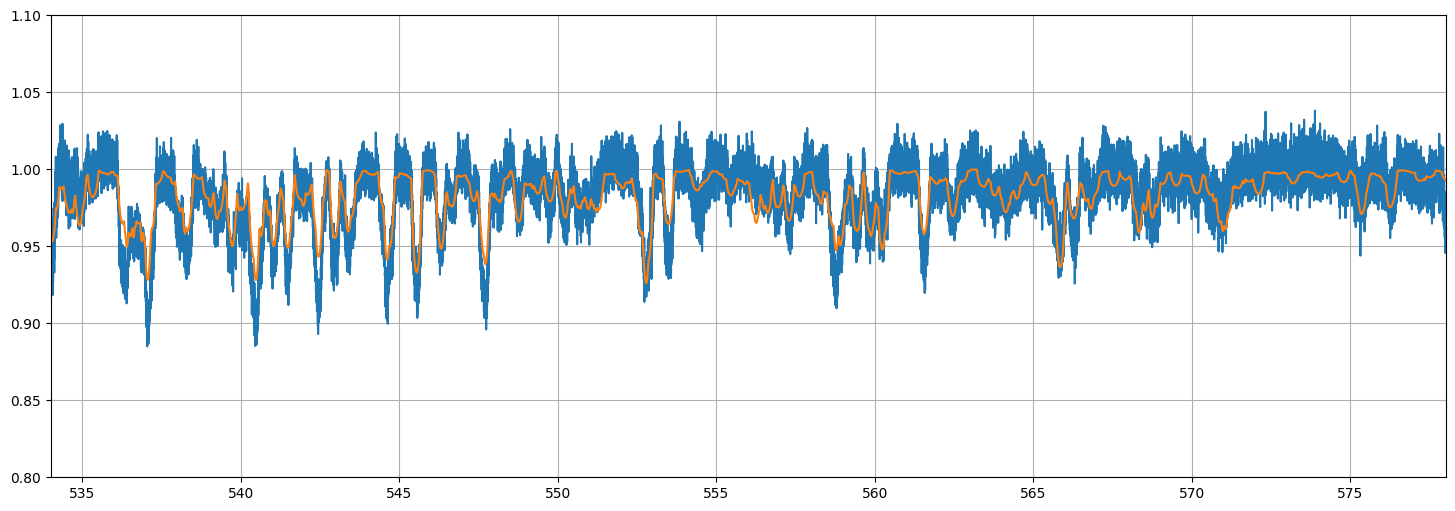

In [97]:
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe3, flux_Fe_norm3[0])
plt.plot(wl_model, flux_model)
plt.xlim(534, 578)
plt.ylim(0.8, 1.1)
plt.grid()

(565.0004844373605, 566.9995993749948)

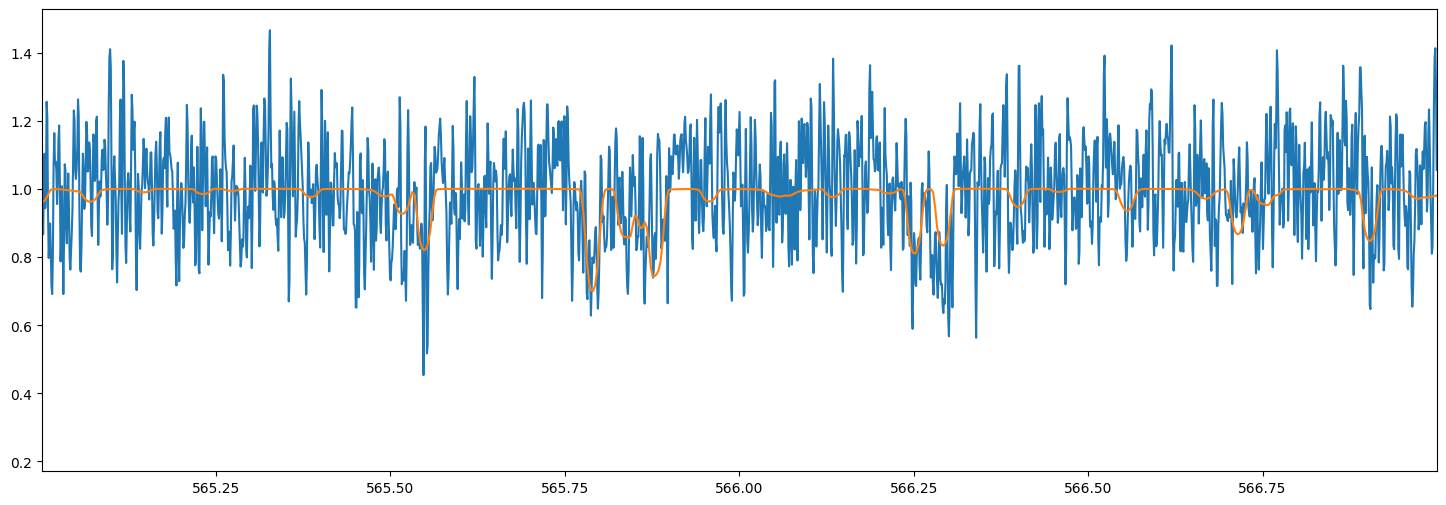

In [108]:
wl_mask = (wl_Fe > 565) & (wl_Fe < 567)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]

mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask/np.nanmedian(FstarN1_mask))
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
# plt.plot(wl_Fe5[wl_mask], FstarN5_mask)
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))

In [109]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night1.append(FstarN1_mask / np.nanmedian(FstarN1_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night2.append(FstarN2_mask / np.nanmedian(FstarN2_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night3.append(FstarN3_mask / np.nanmedian(FstarN3_mask))

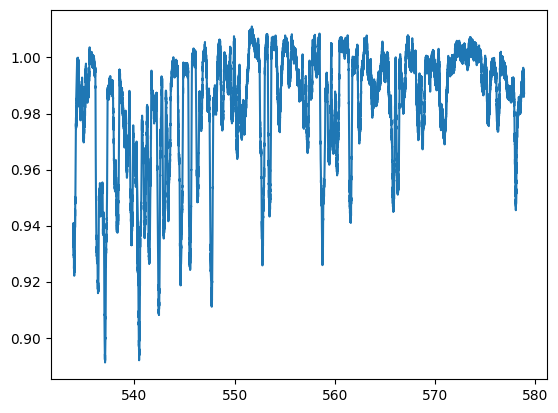

In [79]:
mean_Foot = np.mean(np.vstack((F_oot1, F_oot2, F_oot3)), axis=0)
plt.plot(wl_Fe, mean_Foot)

In [80]:
wl_all_broad.append(wl_Fe)
flux_all_broad.append(mean_Foot)

Ca mask

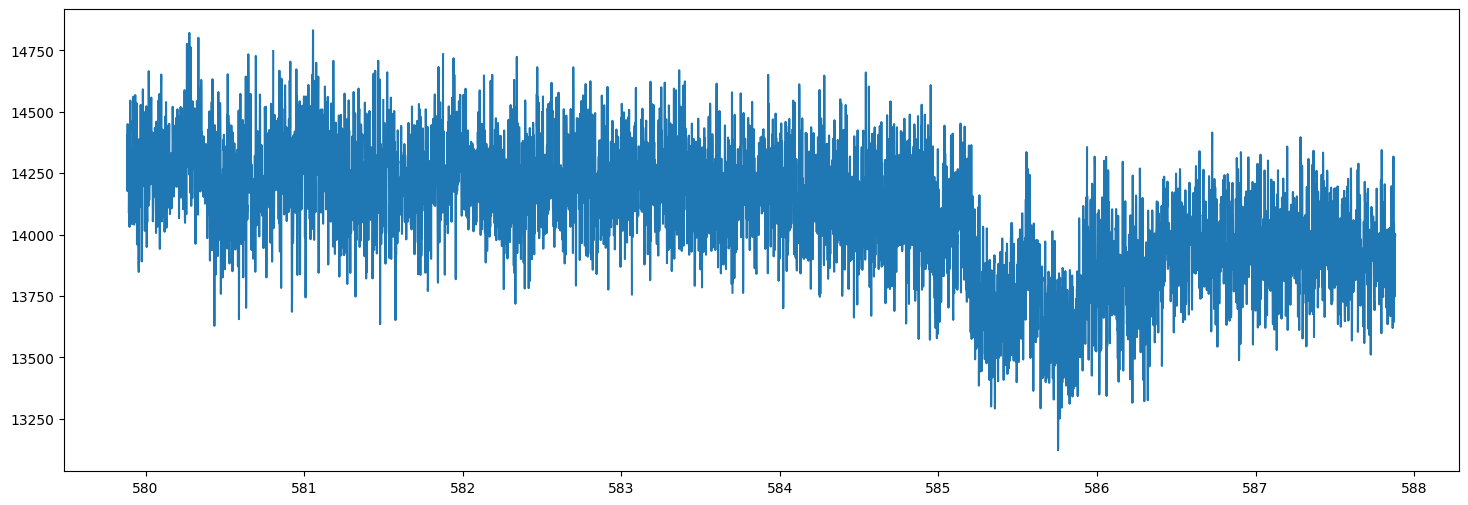

In [81]:
Fe_line_mask4 = (wl2 < 588) & (wl2 > 580)
wl_Fe = ops.vactoair(wl2[Fe_line_mask4]) * doppler_shift1
flux_Fe2 = flux2[:, Fe_line_mask4]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])

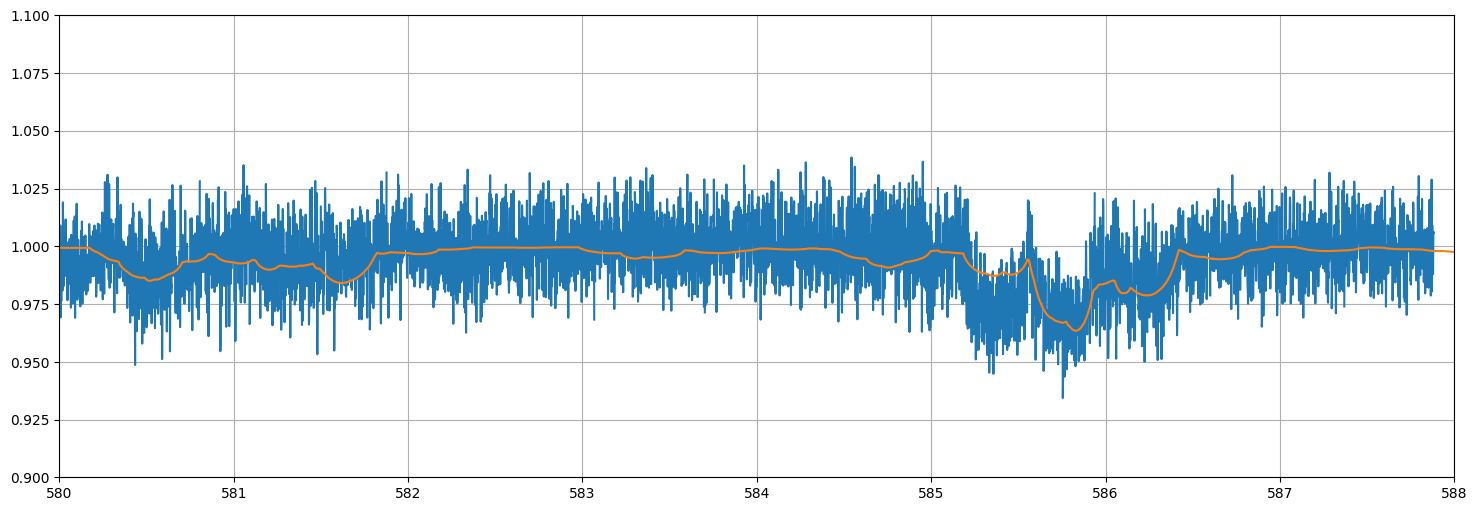

In [106]:
Fe_cont_mask = ((wl_Fe > 582.4) & (wl_Fe < 583)) | (
    (wl_Fe > 586.9) & (wl_Fe < 587.1) | (wl_Fe > 584.0) & (wl_Fe < 584.3)
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe))

F_oot2 = np.nanmean((flux_Fe_norm2[out_of_transit_idx2]), axis=0).flatten()
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe, F_oot)
# plt.plot(wl_Fe, p(wl_Fe))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(580, 588)
plt.ylim(0.9, 1.1)
plt.grid()

In [107]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [108]:
Fe_line_mask4 = (wl1 < 588) & (wl1 > 580)
wl_Fe1 = ops.vactoair(wl1[Fe_line_mask4]) * doppler_shift1
flux_Fe1 = flux1[:, Fe_line_mask4]

Fe_cont_mask = ((wl_Fe1 > 582.4) & (wl_Fe1 < 583)) | (
    (wl_Fe1 > 586.9) & (wl_Fe1 < 587.1) | (wl_Fe1 > 584.0) & (wl_Fe1 < 584.3)
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1))

F_oot1 = np.nanmean((flux_Fe_norm1[out_of_transit_idx1]), axis=0).flatten()
F_oot1 = interp1d(wl_Fe1, F_oot1, bounds_error=False)(wl_Fe)

In [109]:
FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [110]:
Fe_line_mask4 = (wl3 < 588) & (wl3 > 580)
wl_Fe3 = ops.vactoair(wl3[Fe_line_mask4]) * doppler_shift1
flux_Fe3 = flux3[:, Fe_line_mask4]


Fe_cont_mask = ((wl_Fe3 > 582.4) & (wl_Fe3 < 583)) | (
    (wl_Fe3 > 586.9) & (wl_Fe3 < 587.1) | (wl_Fe3 > 584.0) & (wl_Fe3 < 584.3)
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3))

F_oot3 = np.nanmean((flux_Fe_norm3[out_of_transit_idx3]), axis=0).flatten()
F_oot3 = interp1d(wl_Fe3, F_oot3, bounds_error=False)(wl_Fe)
FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(585.000634338435, 586.999749277633)

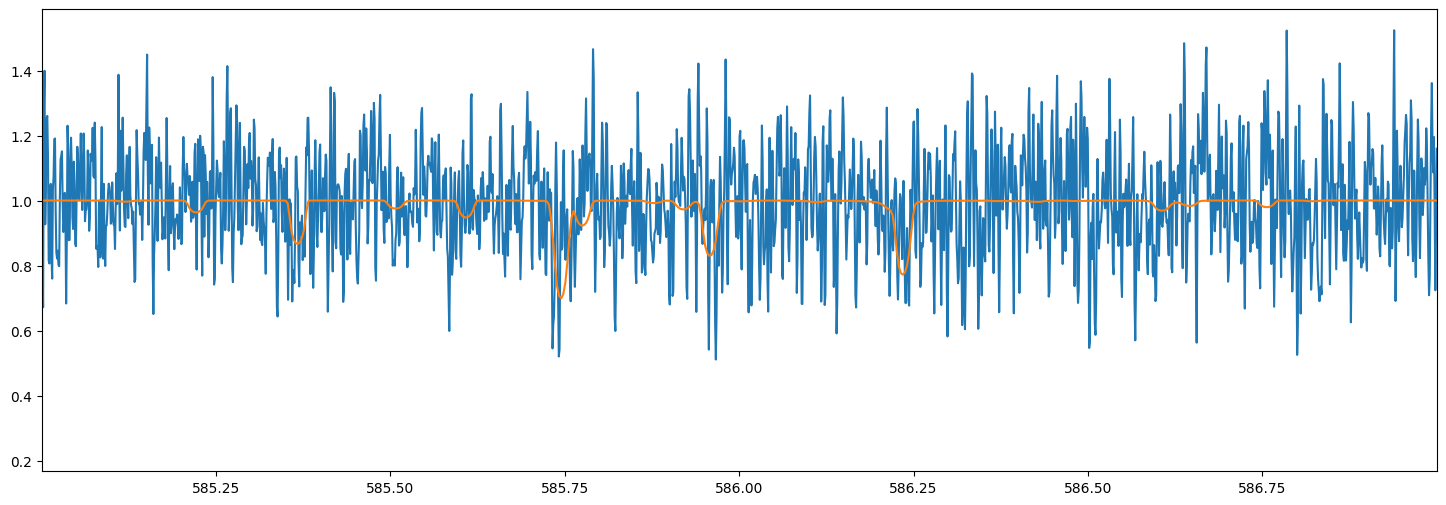

In [111]:
wl_mask = (wl_Fe > 585) & (wl_Fe < 587)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]

mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask/np.nanmedian(FstarN1_mask))
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))

In [190]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)

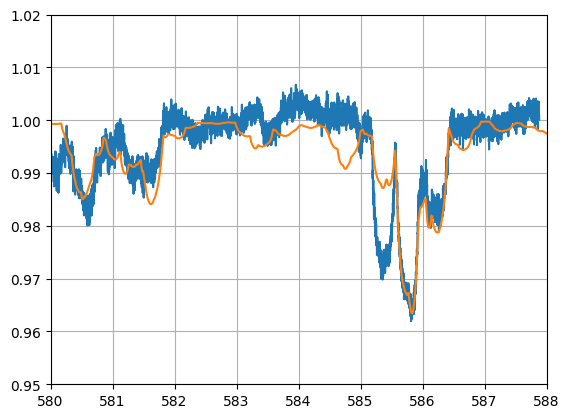

In [112]:
mean_Foot = np.mean(np.vstack((F_oot1, F_oot2, F_oot3)), axis=0)
plt.plot(wl_Fe, mean_Foot)
plt.plot(wl_model, flux_model)
plt.xlim(580, 588)
plt.ylim(0.95, 1.02)
plt.grid()

In [113]:
wl_all_broad.append(wl_Fe)
flux_all_broad.append(mean_Foot)

Segment 4

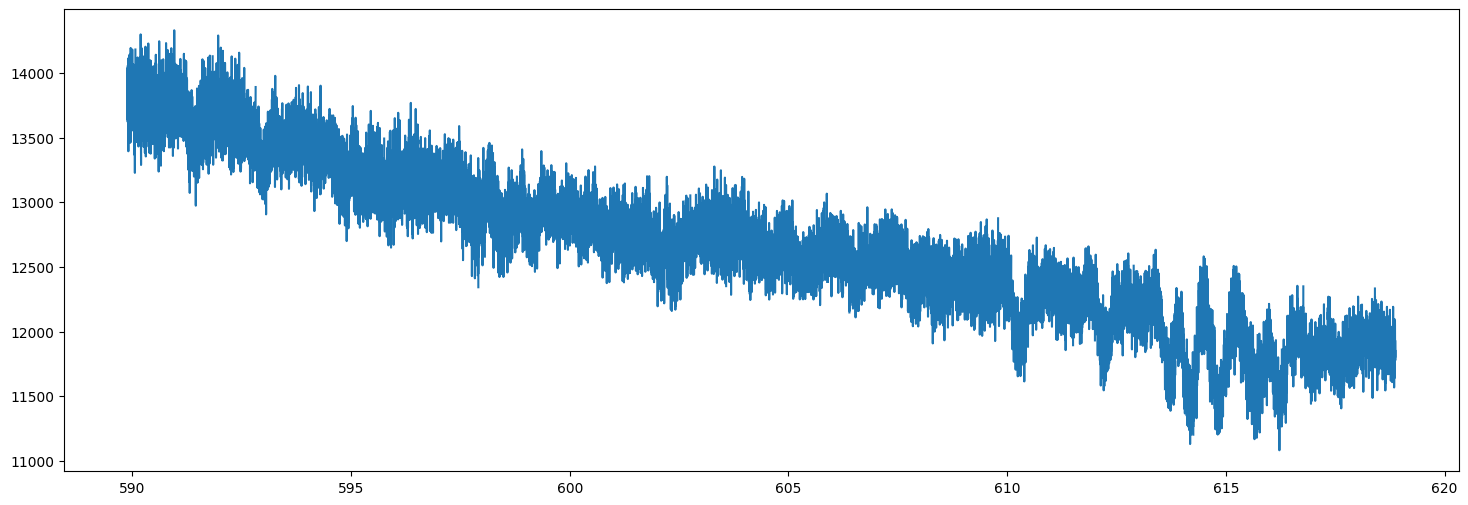

In [110]:
Fe_line_mask4 = (wl2 < 619) & (wl2 > 590)
wl_Fe = ops.vactoair(wl2[Fe_line_mask4]) * doppler_shift1
flux_Fe2 = flux2[:, Fe_line_mask4]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])

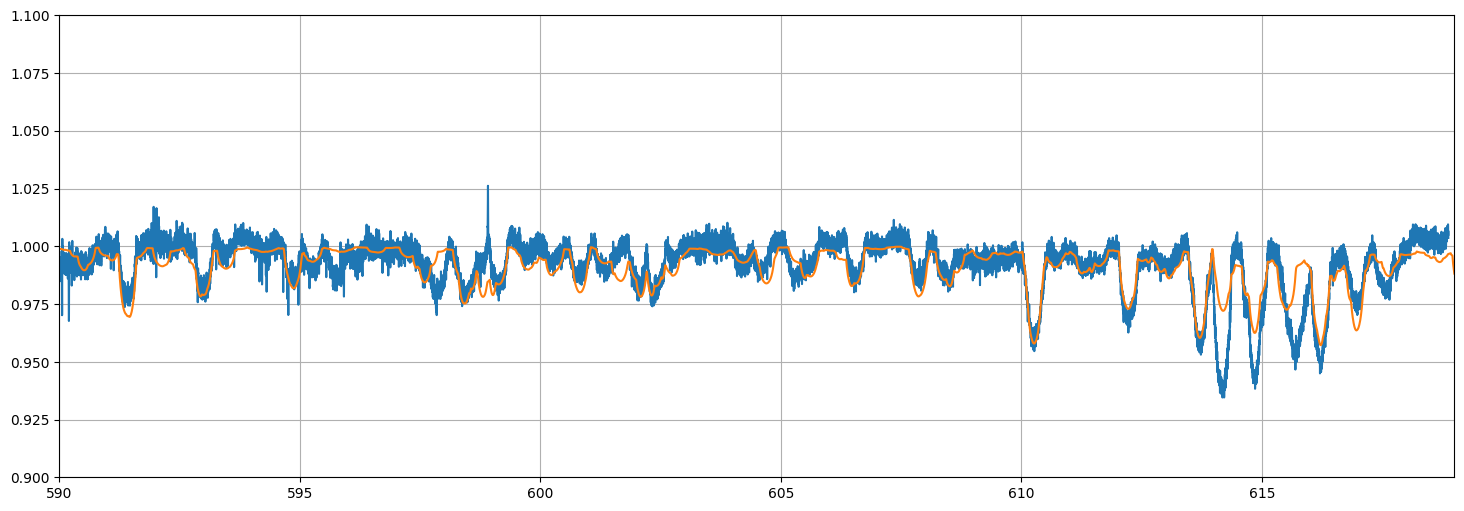

In [111]:
Fe_cont_mask = (
    ((wl_Fe > 592.2) & (wl_Fe < 592.5))
    | ((wl_Fe > 596.4) & (wl_Fe < 597.4))
    | ((wl_Fe > 603) & (wl_Fe < 604))
    | ((wl_Fe > 605.7) & (wl_Fe < 606.2))
    | ((wl_Fe > 606.7) & (wl_Fe < 607.8))
    | ((wl_Fe > 611.8) & (wl_Fe < 612))
    | ((wl_Fe > 590.8) & (wl_Fe < 590.85))
    | ((wl_Fe > 593.8) & (wl_Fe < 594.6))
    | ((wl_Fe > 613.4) & (wl_Fe < 613.5))
    | ((wl_Fe > 613.9) & (wl_Fe < 614))
    | ((wl_Fe > 617.85) & (wl_Fe < 618.35))
    | ((wl_Fe > 590.8) & (wl_Fe < 590.85))
    | ((wl_Fe > 591.8) & (wl_Fe < 591.9))
    | ((wl_Fe > 607.1) & (wl_Fe < 607.4))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 3)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe))

F_oot2 = np.nanmean((flux_Fe_norm2[out_of_transit_idx2]), axis=0).flatten()
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, F_oot2)
# plt.plot(wl_Fe, p(wl_Fe))
# plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(590, 619)
plt.ylim(0.9, 1.1)
plt.grid()

In [112]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [113]:
Fe_line_mask4 = (wl1 < 619) & (wl1 > 590)
wl_Fe1 = ops.vactoair(wl1[Fe_line_mask4]) * doppler_shift1
flux_Fe1 = flux1[:, Fe_line_mask4]


Fe_cont_mask = (
    ((wl_Fe1 > 592.2) & (wl_Fe1 < 592.5))
    | ((wl_Fe1 > 596.4) & (wl_Fe1 < 597.4))
    | ((wl_Fe1 > 603) & (wl_Fe1 < 604))
    | ((wl_Fe1 > 605.7) & (wl_Fe1 < 606.2))
    | ((wl_Fe1 > 606.7) & (wl_Fe1 < 607.8))
    | ((wl_Fe1 > 611.8) & (wl_Fe1 < 612))
    | ((wl_Fe1 > 590.8) & (wl_Fe1 < 590.85))
    | ((wl_Fe1 > 593.8) & (wl_Fe1 < 594.6))
    | ((wl_Fe1 > 613.4) & (wl_Fe1 < 613.5))
    | ((wl_Fe1 > 613.9) & (wl_Fe1 < 614))
    | ((wl_Fe1 > 617.85) & (wl_Fe1 < 618.35))
    | ((wl_Fe1 > 590.8) & (wl_Fe1 < 590.85))
    | ((wl_Fe1 > 591.8) & (wl_Fe1 < 591.9))
    | ((wl_Fe1 > 607.1) & (wl_Fe1 < 607.4))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 3)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1))

F_oot1 = np.nanmean((flux_Fe_norm1[out_of_transit_idx1]), axis=0).flatten()
F_oot1 = interp1d(wl_Fe1, F_oot1, bounds_error=False)(wl_Fe)
FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [114]:
Fe_line_mask4 = (wl3 < 619) & (wl3 > 590)
wl_Fe3 = ops.vactoair(wl3[Fe_line_mask4]) * doppler_shift1
flux_Fe3 = flux3[:, Fe_line_mask4]


Fe_cont_mask = (
    ((wl_Fe3 > 592.2) & (wl_Fe3 < 592.5))
    | ((wl_Fe3 > 596.4) & (wl_Fe3 < 597.4))
    | ((wl_Fe3 > 603) & (wl_Fe3 < 604))
    | ((wl_Fe3 > 605.7) & (wl_Fe3 < 606.2))
    | ((wl_Fe3 > 606.7) & (wl_Fe3 < 607.8))
    | ((wl_Fe3 > 611.8) & (wl_Fe3 < 612))
    | ((wl_Fe3 > 590.8) & (wl_Fe3 < 590.85))
    | ((wl_Fe3 > 593.8) & (wl_Fe3 < 594.6))
    | ((wl_Fe3 > 613.4) & (wl_Fe3 < 613.5))
    | ((wl_Fe3 > 613.9) & (wl_Fe3 < 614))
    | ((wl_Fe3 > 617.85) & (wl_Fe3 < 618.35))
    | ((wl_Fe3 > 590.8) & (wl_Fe3 < 590.85))
    | ((wl_Fe3 > 591.8) & (wl_Fe3 < 591.9))
    | ((wl_Fe3 > 607.1) & (wl_Fe3 < 607.4))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 3)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3))

F_oot3 = np.nanmean((flux_Fe_norm3[out_of_transit_idx3]), axis=0).flatten()
F_oot3 = interp1d(wl_Fe3, F_oot3, bounds_error=False)(wl_Fe)
FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(613.0002441893579, 614.9993591303528)

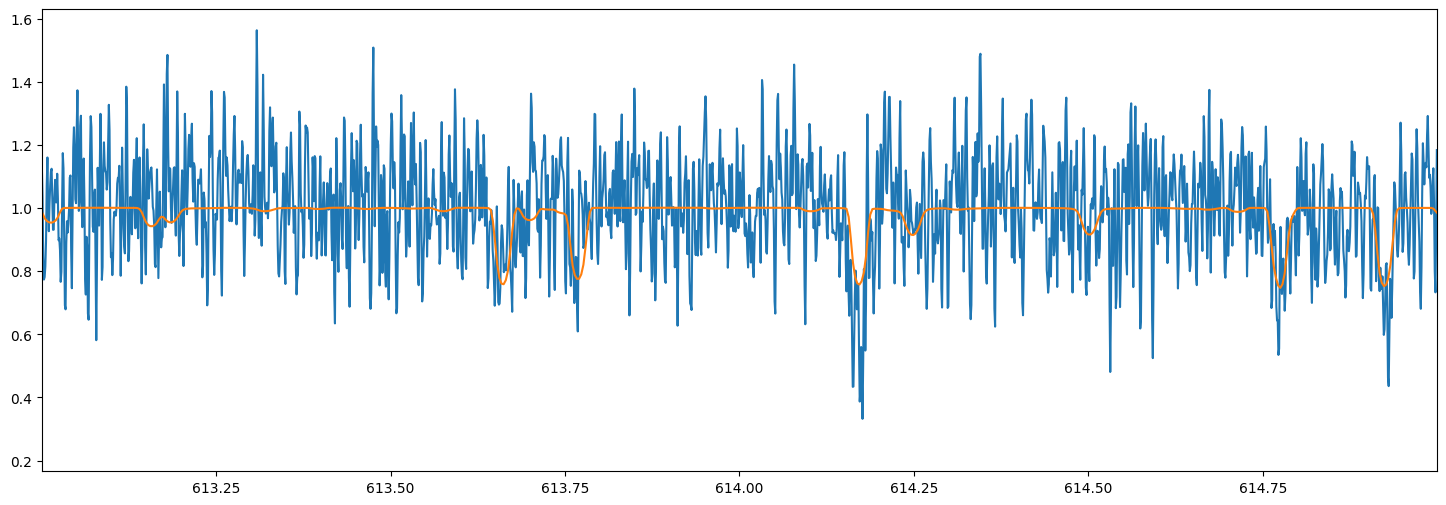

In [119]:
wl_mask = (wl_Fe > 613) & (wl_Fe < 615)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]

mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask/np.nanmedian(FstarN1_mask))
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))

In [120]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night1.append(FstarN1_mask / np.nanmedian(FstarN1_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night2.append(FstarN2_mask / np.nanmedian(FstarN2_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night3.append(FstarN3_mask / np.nanmedian(FstarN3_mask))

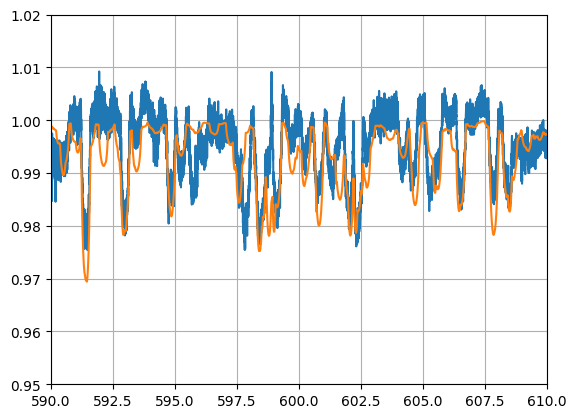

In [138]:
mean_Foot = np.mean(np.vstack((F_oot1, F_oot2, F_oot3)), axis=0)
plt.plot(wl_Fe, mean_Foot)
plt.plot(wl_model, flux_model)
plt.xlim(590, 610)
plt.ylim(0.95, 1.02)
plt.grid()

In [139]:
wl_all_broad.append(wl_Fe)
flux_all_broad.append(mean_Foot)

Segment 5

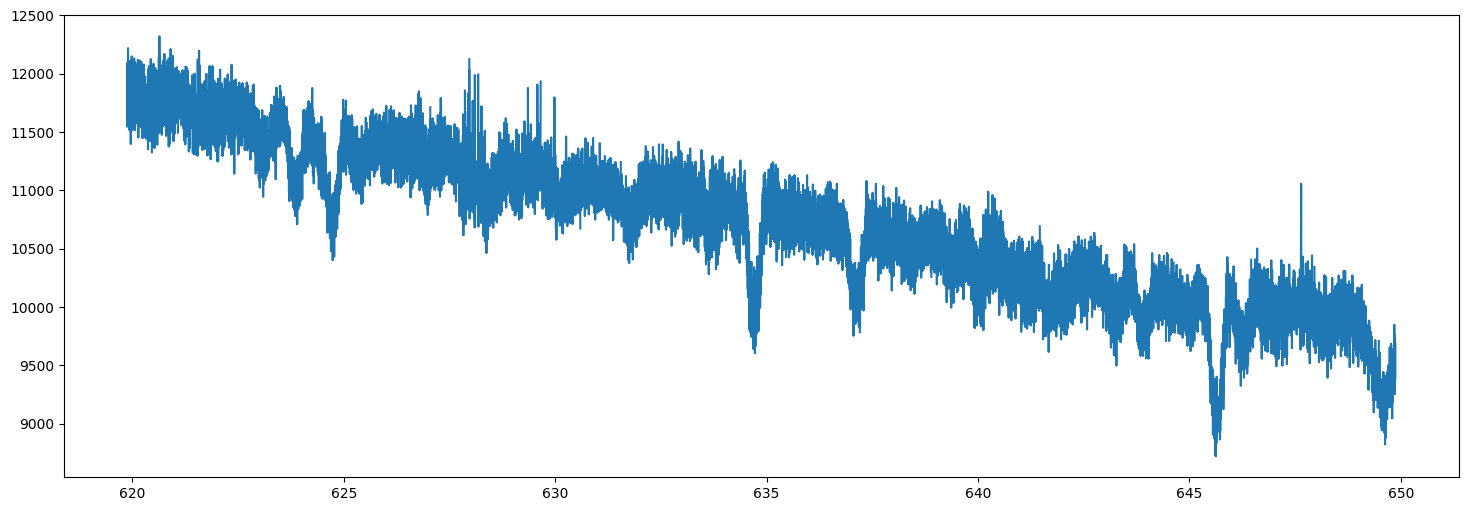

In [121]:
Fe_line_mask5 = (wl2 < 650) & (wl2 > 620)
wl_Fe = ops.vactoair(wl2[Fe_line_mask5]) * doppler_shift1
flux_Fe2 = flux2[:, Fe_line_mask5]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])

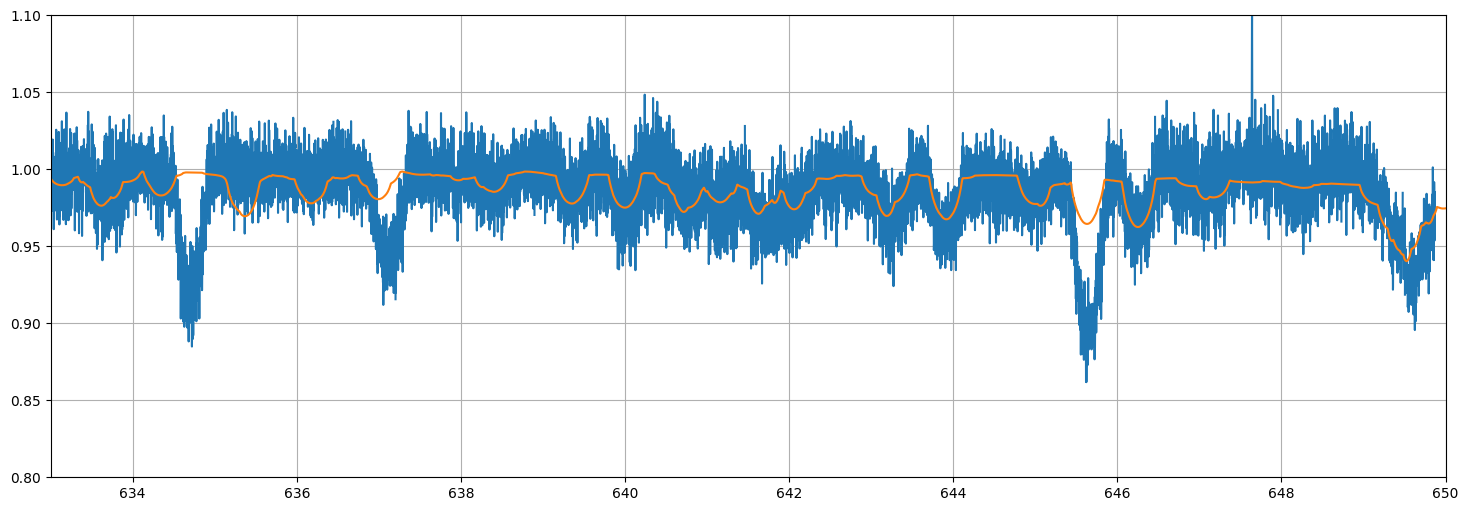

In [122]:
Fe_cont_mask = (
    ((wl_Fe > 625.0) & (wl_Fe < 625.1))
    | ((wl_Fe > 623.5) & (wl_Fe < 623.6))
    | ((wl_Fe > 632.5) & (wl_Fe < 633))
    | ((wl_Fe > 640.2) & (wl_Fe < 640.5))
    | ((wl_Fe > 620.2) & (wl_Fe < 620.25))
    | ((wl_Fe > 621.0) & (wl_Fe < 621.1))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe))

F_oot2 = np.nanmean((flux_Fe_norm2[out_of_transit_idx2]), axis=0).flatten()

plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe, F_oot)
# plt.plot(wl_Fe, p(wl_Fe))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(633, 650)
plt.ylim(0.8, 1.1)
plt.grid()

In [123]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [124]:
Fe_line_mask5 = (wl1 < 650) & (wl1 > 620)
wl_Fe1 = ops.vactoair(wl1[Fe_line_mask5]) * doppler_shift1
flux_Fe1 = flux1[:, Fe_line_mask5]


Fe_cont_mask = (
    ((wl_Fe1 > 625.0) & (wl_Fe1 < 625.1))
    | ((wl_Fe1 > 623.5) & (wl_Fe1 < 623.6))
    | ((wl_Fe1 > 632.5) & (wl_Fe1 < 633))
    | ((wl_Fe1 > 640.2) & (wl_Fe1 < 640.5))
    | ((wl_Fe1 > 620.2) & (wl_Fe1 < 620.25))
    | ((wl_Fe1 > 621.0) & (wl_Fe1 < 621.1))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1))

F_oot1 = np.nanmean((flux_Fe_norm1[out_of_transit_idx1]), axis=0).flatten()
F_oot1 = interp1d(wl_Fe1, F_oot1, bounds_error=False)(wl_Fe)
FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [125]:
Fe_line_mask5 = (wl3 < 650) & (wl3 > 620)
wl_Fe3 = ops.vactoair(wl3[Fe_line_mask5]) * doppler_shift1
flux_Fe3 = flux3[:, Fe_line_mask5]


Fe_cont_mask = (
    ((wl_Fe3 > 625.0) & (wl_Fe3 < 625.1))
    | ((wl_Fe3 > 623.5) & (wl_Fe3 < 623.6))
    | ((wl_Fe3 > 632.5) & (wl_Fe3 < 633))
    | ((wl_Fe3 > 640.2) & (wl_Fe3 < 640.5))
    | ((wl_Fe3 > 620.2) & (wl_Fe3 < 620.25))
    | ((wl_Fe3 > 621.0) & (wl_Fe3 < 621.1))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3))

F_oot3 = np.nanmean((flux_Fe_norm3[out_of_transit_idx3]), axis=0).flatten()
F_oot3 = interp1d(wl_Fe3, F_oot3, bounds_error=False)(wl_Fe)
FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(639.0007391205883, 640.9998540629147)

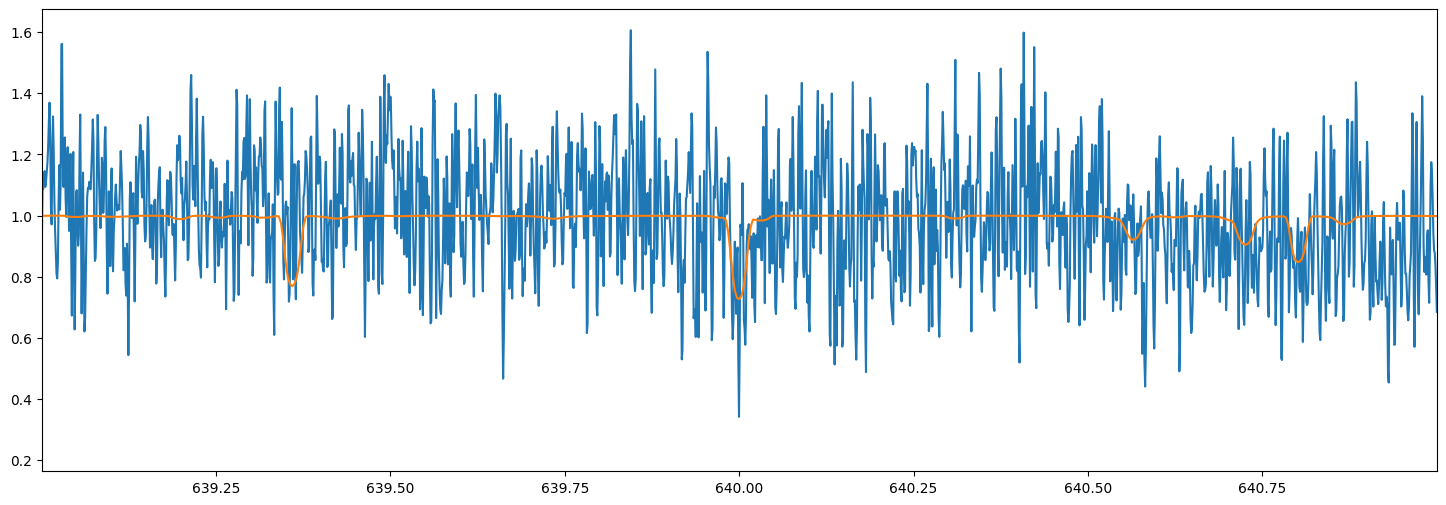

In [130]:
wl_mask = (wl_Fe > 639) & (wl_Fe < 641)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]

mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask / np.nanmedian(FstarN1_mask),
            FstarN2_mask / np.nanmedian(FstarN2_mask),
            FstarN3_mask / np.nanmedian(FstarN3_mask),
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask/np.nanmedian(FstarN1_mask))
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
# plt.plot(wl_Fe[wl_mask],FstarN3_mask/np.nanmedian(FstarN3_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))

In [131]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night1.append(FstarN1_mask / np.nanmedian(FstarN1_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night2.append(FstarN2_mask / np.nanmedian(FstarN2_mask))

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night3.append(FstarN3_mask / np.nanmedian(FstarN3_mask))

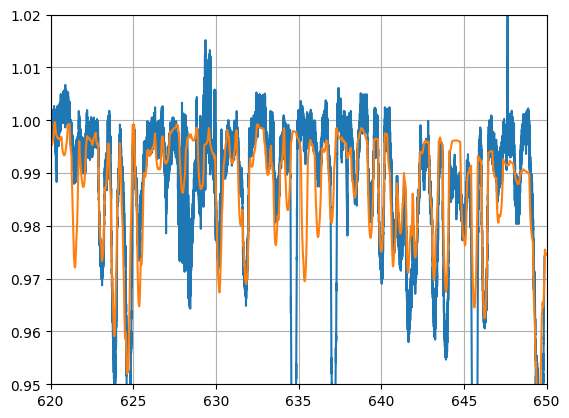

In [159]:
mean_Foot = np.mean(np.vstack((F_oot1, F_oot2, F_oot3)), axis=0)
plt.plot(wl_Fe, mean_Foot)
plt.plot(wl_model, flux_model)
plt.xlim(620, 650)
plt.ylim(0.95, 1.02)
plt.grid()

In [160]:
wl_all_broad.append(wl_Fe)
flux_all_broad.append(mean_Foot)

Segment 6

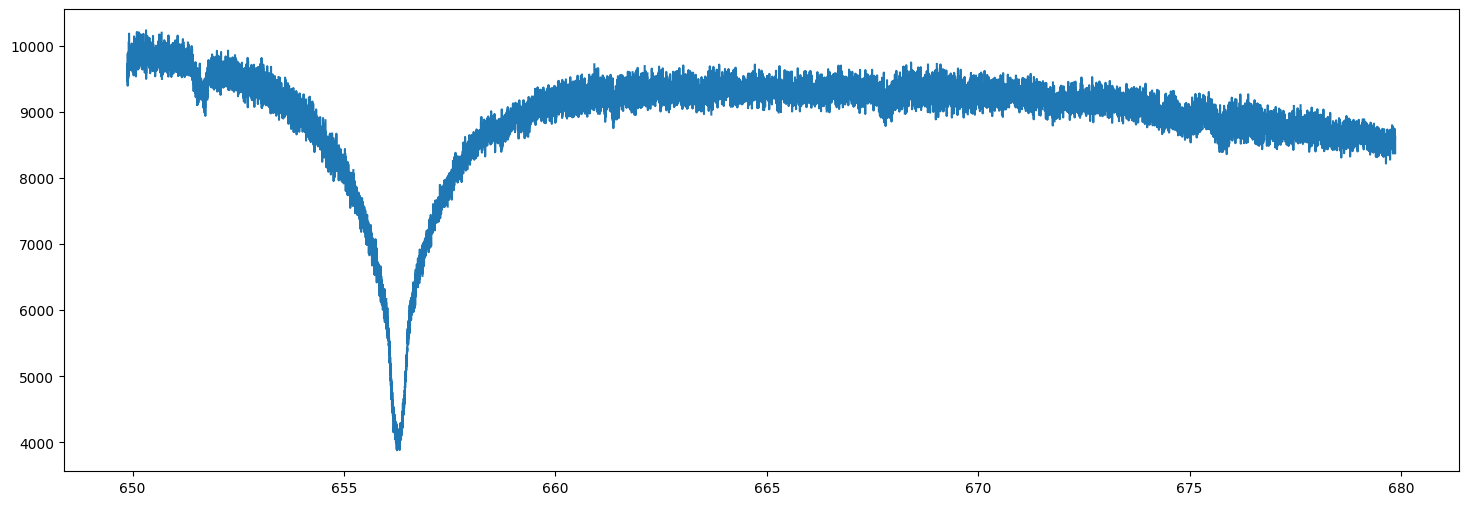

In [132]:
Fe_line_mask6 = (wl2 < 680) & (wl2 > 650)
wl_Fe = ops.vactoair(wl2[Fe_line_mask6]) * doppler_shift1
flux_Fe2 = flux2[:, Fe_line_mask6]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])

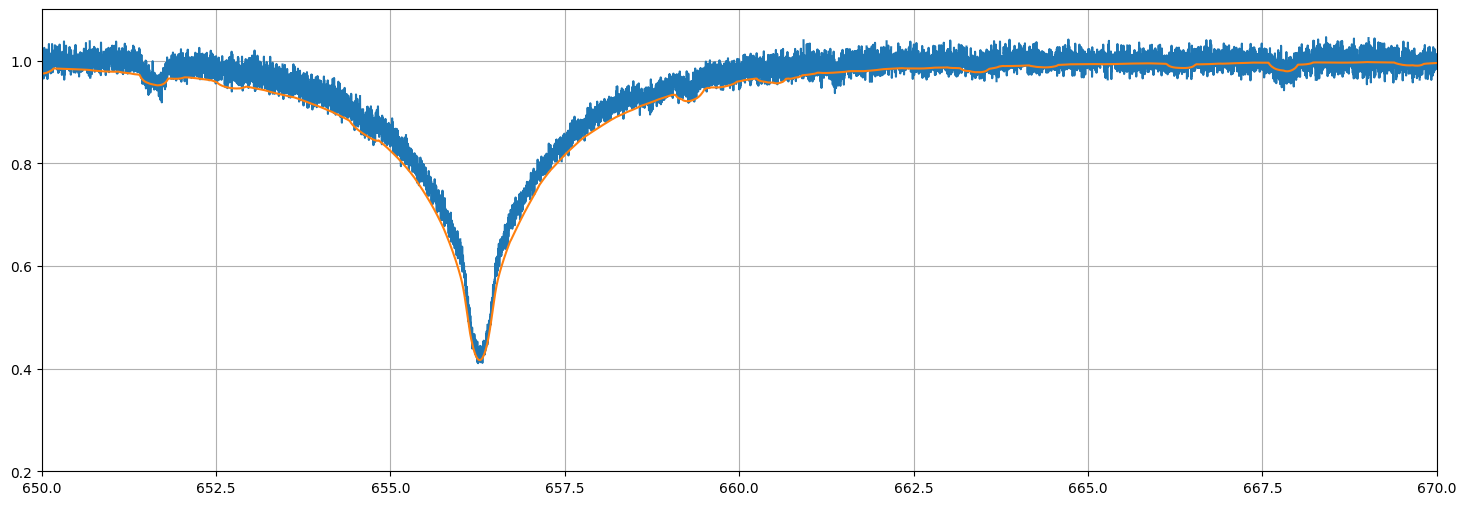

In [133]:
Fe_cont_mask = (
    # ((wl_Fe > 660.7) & (wl_Fe < 661.2))
    ((wl_Fe > 663) & (wl_Fe < 663.2))
    | ((wl_Fe > 650.1) & (wl_Fe < 651.2))
    | ((wl_Fe > 664.5) & (wl_Fe < 665))
    | ((wl_Fe > 668) & (wl_Fe < 669.5))
    | ((wl_Fe > 665) & (wl_Fe < 666))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 3)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe))

F_oot2 = np.nanmean((flux_Fe_norm2[out_of_transit_idx2]), axis=0).flatten()

plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe, F_oot)
# plt.plot(wl_Fe, p(wl_Fe))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(650, 670)
plt.ylim(0.2, 1.1)
plt.grid()

In [134]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

In [135]:
Fe_line_mask6 = (wl1 < 670) & (wl1 > 650)
wl_Fe1 = ops.vactoair(wl1[Fe_line_mask6]) * doppler_shift1
flux_Fe1 = flux1[:, Fe_line_mask6]


Fe_cont_mask = (
    ((wl_Fe1 > 663) & (wl_Fe1 < 663.2))
    | ((wl_Fe1 > 650.1) & (wl_Fe1 < 651.2))
    | ((wl_Fe1 > 664.5) & (wl_Fe1 < 665))
    | ((wl_Fe1 > 668) & (wl_Fe1 < 669.5))
    | ((wl_Fe1 > 665) & (wl_Fe1 < 666))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 3)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1))

F_oot1 = np.nanmean((flux_Fe_norm1[out_of_transit_idx1]), axis=0).flatten()
F_oot1 = interp1d(wl_Fe1, F_oot1, bounds_error=False)(wl_Fe)
FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)
FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

In [136]:
Fe_line_mask6 = (wl3 < 670) & (wl3 > 650)
wl_Fe3 = ops.vactoair(wl3[Fe_line_mask6]) * doppler_shift1
flux_Fe3 = flux3[:, Fe_line_mask6]

Fe_cont_mask = (
    ((wl_Fe3 > 663) & (wl_Fe3 < 663.2))
    | ((wl_Fe3 > 650.1) & (wl_Fe3 < 651.2))
    | ((wl_Fe3 > 664.5) & (wl_Fe3 < 665))
    | ((wl_Fe3 > 668) & (wl_Fe3 < 669.5))
    | ((wl_Fe3 > 665) & (wl_Fe3 < 666))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 3)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3))

F_oot3 = np.nanmean((flux_Fe_norm3[out_of_transit_idx3]), axis=0).flatten()
F_oot3 = interp1d(wl_Fe3, F_oot3, bounds_error=False)(wl_Fe)

FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

(650.0, 662.0)

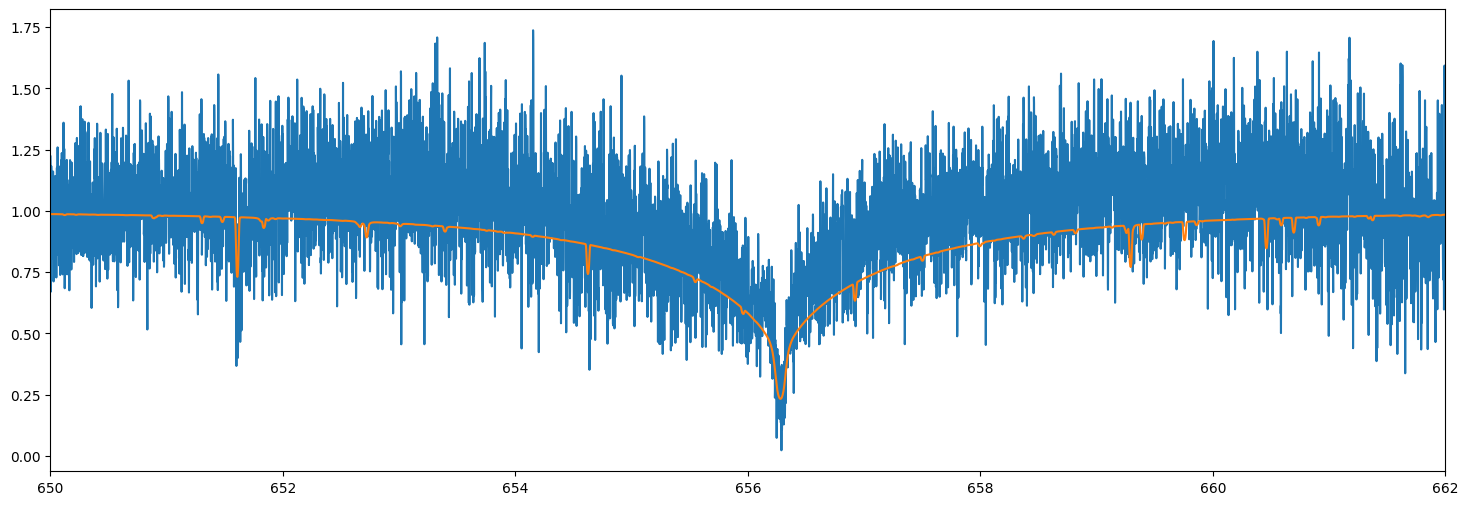

In [137]:
wl_mask = (wl_Fe > 650) & (wl_Fe < 662)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]

mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask,
            FstarN2_mask,
            FstarN3_mask,
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask)
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
# plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))
plt.xlim(650, 662)

In [138]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night1.append(FstarN1_mask)

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night2.append(FstarN2_mask)

# wl_night1.append(wl_Fe[wl_mask])
# FstarN_night3.append(FstarN3_mask)

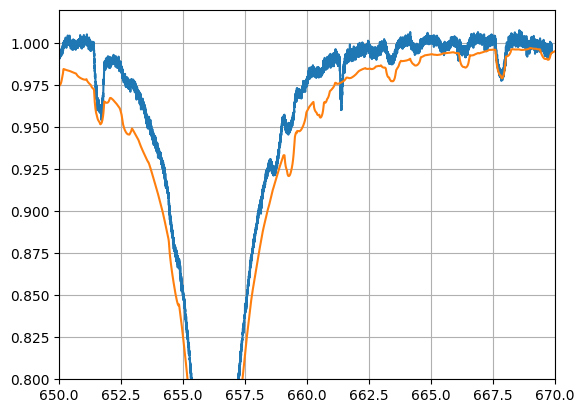

In [194]:
mean_Foot = np.mean(np.vstack((F_oot1, F_oot2, F_oot3)), axis=0)
plt.plot(wl_Fe, mean_Foot)
plt.plot(wl_model, flux_model)
plt.xlim(650, 670)
plt.ylim(0.8, 1.02)
plt.grid()

In [195]:
wl_all_broad.append(wl_Fe)
flux_all_broad.append(mean_Foot)

Ti

Si

(670.0, 685.0)

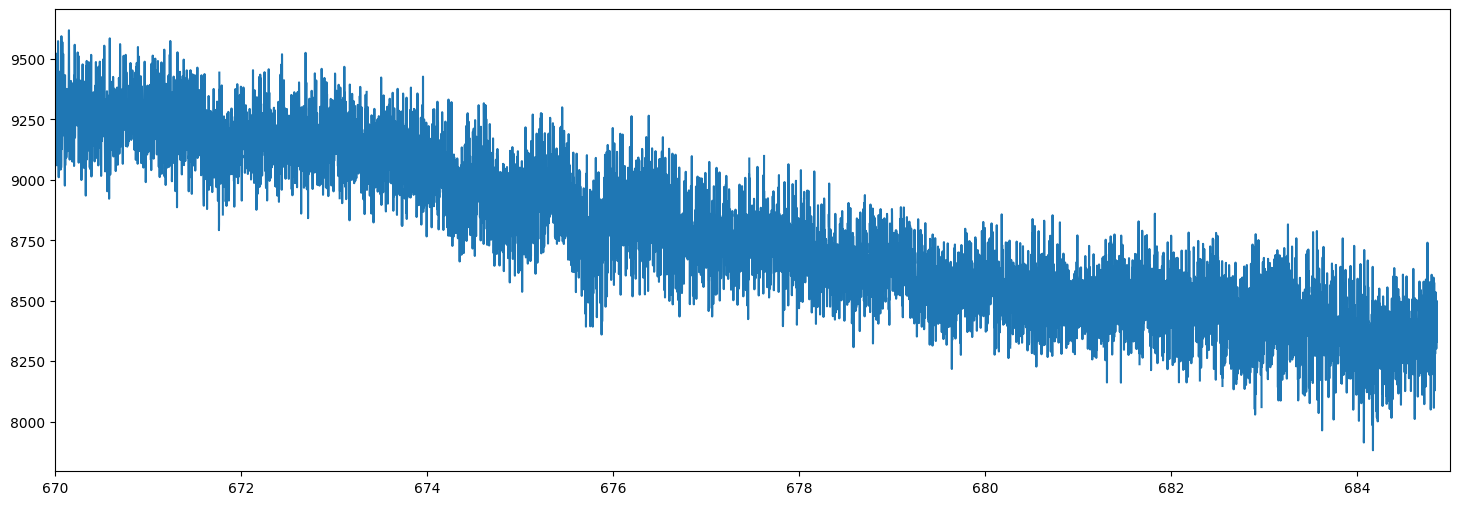

In [82]:
Mg_line_mask = (wl2 > 670) & (wl2 < 685)
wl_Fe = ops.vactoair(wl2[Mg_line_mask]) * doppler_shift1
flux_Fe2 = flux2[:, Mg_line_mask]
plt.figure(figsize=(18, 6))
plt.plot(wl_Fe, flux_Fe2[0])
plt.xlim(670, 685)

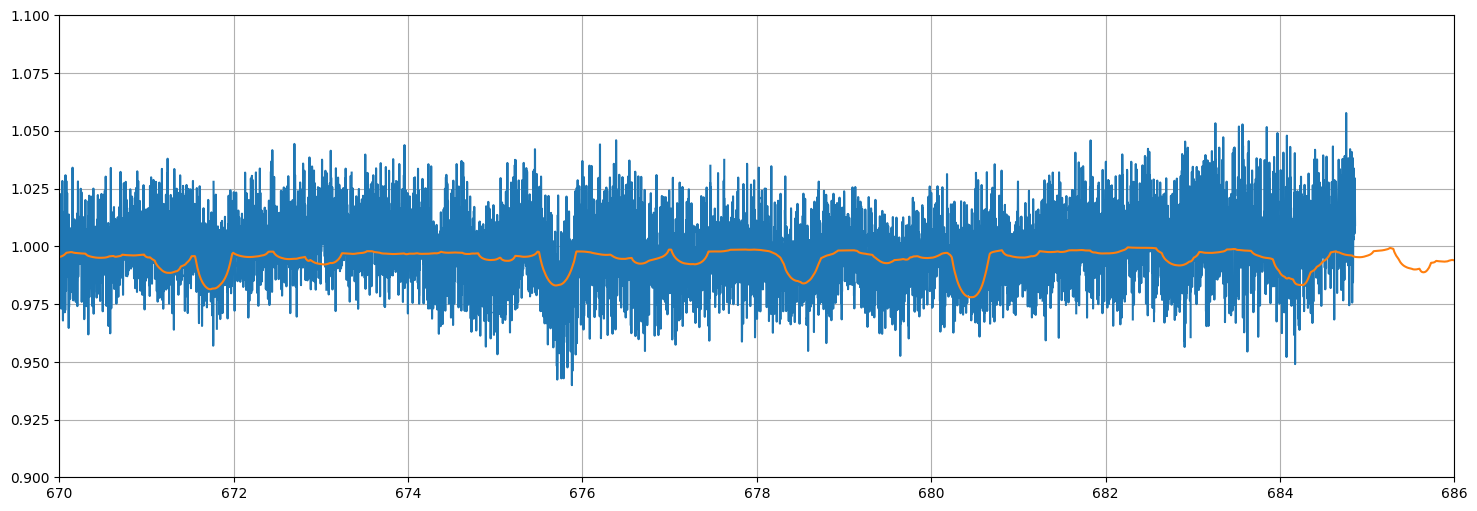

In [88]:
F_oot = np.nanmean((flux_Fe2[out_of_transit_idx2]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe > 673.5) & (wl_Fe < 674.8))
    | ((wl_Fe > 677.2) & (wl_Fe < 678.1))
    | ((wl_Fe > 682.2) & (wl_Fe < 682.5))
)

flux_Fe_norm2 = np.empty_like(flux_Fe2)
for i in range(len(flux_Fe2[:, 0])):
    w = wl_Fe[Fe_cont_mask]
    f = flux_Fe2[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm2[i] = flux_Fe2[i] / (p(wl_Fe))

plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe, F_oot)
# plt.plot(wl_Fe, p(wl_Fe))
plt.plot(wl_Fe, flux_Fe_norm2[0])
plt.plot(wl_model, flux_model)
plt.xlim(670, 686)
plt.ylim(0.9, 1.1)
plt.grid()

In [90]:
FstarN2 = narrow_spectrum.compute_FstarN(
    wl_Fe,
    flux_Fe_norm2,
    xp2,
    yp2,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx2,
    out_of_transit_idx2,
)

Mg_line_mask = (wl1 > 670) & (wl1 < 685)
wl_Fe1 = ops.vactoair(wl1[Mg_line_mask]) * doppler_shift1
flux_Fe1 = flux1[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe3[out_of_transit_idx3]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe1 > 673.5) & (wl_Fe1 < 674.8))
    | ((wl_Fe1 > 677.2) & (wl_Fe1 < 678.1))
    | ((wl_Fe1 > 682.2) & (wl_Fe1 < 682.5))
)

flux_Fe_norm1 = np.empty_like(flux_Fe1)
for i in range(len(flux_Fe1[:, 0])):
    w = wl_Fe1[Fe_cont_mask]
    f = flux_Fe1[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm1[i] = flux_Fe1[i] / (p(wl_Fe1))

FstarN1 = narrow_spectrum.compute_FstarN(
    wl_Fe1,
    flux_Fe_norm1,
    xp1,
    yp1,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx1,
    out_of_transit_idx1,
)

FstarN1 = interp1d(wl_Fe1, FstarN1, bounds_error=False)(wl_Fe)

Mg_line_mask = (wl3 > 670) & (wl3 < 685)
wl_Fe3 = ops.vactoair(wl3[Mg_line_mask]) * doppler_shift1
flux_Fe3 = flux3[:, Mg_line_mask]

F_oot = np.nanmean((flux_Fe3[out_of_transit_idx3]), axis=0).flatten()
Fe_cont_mask = (
    ((wl_Fe3 > 673.5) & (wl_Fe3 < 674.8))
    | ((wl_Fe3 > 677.2) & (wl_Fe3 < 678.1))
    | ((wl_Fe3 > 682.2) & (wl_Fe3 < 682.5))
)

flux_Fe_norm3 = np.empty_like(flux_Fe3)
for i in range(len(flux_Fe3[:, 0])):
    w = wl_Fe3[Fe_cont_mask]
    f = flux_Fe3[i][Fe_cont_mask]
    w = w[~np.isnan(f)]
    f = f[~np.isnan(f)]
    fit = np.polyfit(w, f, 1)
    p = np.poly1d(fit)
    flux_Fe_norm3[i] = flux_Fe3[i] / (p(wl_Fe3))

FstarN3 = narrow_spectrum.compute_FstarN(
    wl_Fe3,
    flux_Fe_norm3,
    xp3,
    yp3,
    RpRs,
    u1,
    u2,
    vsini,
    in_transit_idx3,
    out_of_transit_idx3,
)

FstarN3 = interp1d(wl_Fe3, FstarN3, bounds_error=False)(wl_Fe)

/home/madeline/masters-project/narrow_spectrum.py:9: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)
/home/madeline/masters-project/narrow_spectrum.py:88: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


(679.0000389602791, 680.9991539041615)

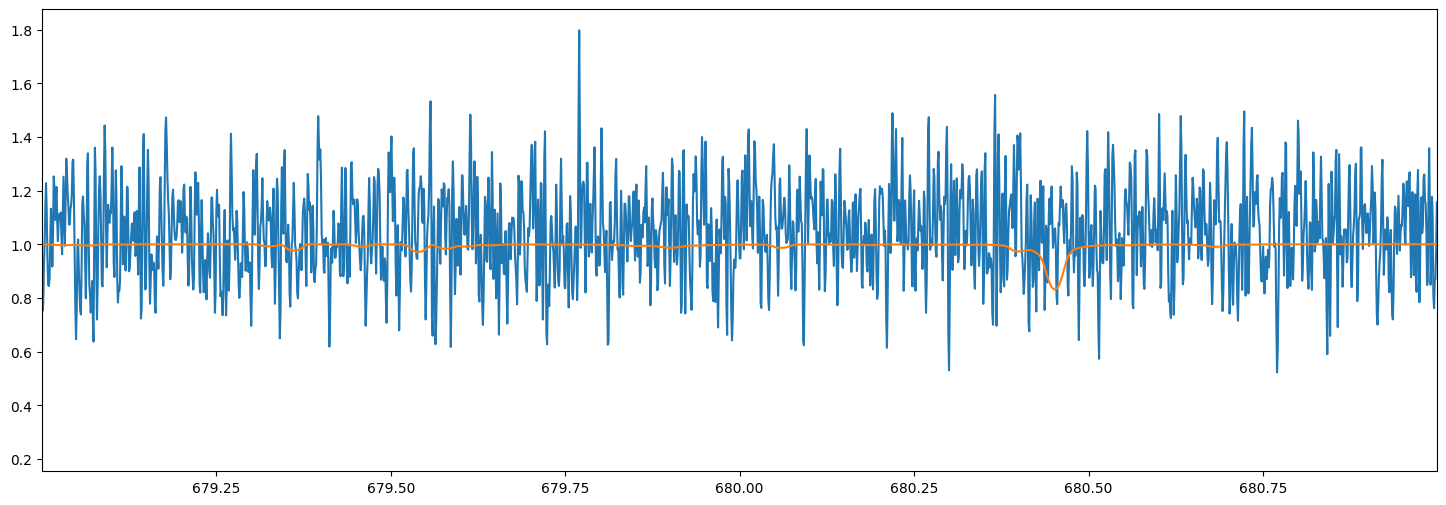

In [91]:
wl_mask = (wl_Fe > 679) & (wl_Fe < 681)
FstarN1_mask = FstarN1[wl_mask]
FstarN2_mask = FstarN2[wl_mask]
FstarN3_mask = FstarN3[wl_mask]

mean_FstarN_mask = np.nanmean(
    np.vstack(
        (
            FstarN1_mask,
            FstarN2_mask,
            FstarN3_mask,
        )
    ),
    axis=0,
)
plt.figure(figsize=(18, 6))
# plt.plot(wl_Fe[wl_mask],FstarN1_mask)
# plt.plot(wl_Fe[wl_mask],FstarN2_mask/np.nanmedian(FstarN2_mask))
plt.plot(wl_Fe[wl_mask], mean_FstarN_mask)
plt.plot(wl_model_narrow, flux_model_narrow)
plt.xlim(np.nanmin(wl_Fe[wl_mask]), np.nanmax(wl_Fe[wl_mask]))

In [92]:
wl_all_Fe.append(wl_Fe[wl_mask])
FstarN_all_Fe.append(mean_FstarN_mask)

In [139]:
wl_all_Fe_array = np.concatenate(wl_all_Fe, axis=0)
flux_all_Fe_array = np.concatenate(FstarN_all_Fe, axis=0)

# wl_night1_array = np.concatenate(wl_night1, axis=0)
# flux_night1_array = np.concatenate(FstarN_night1, axis=0)

# wl_night2_array = np.concatenate(wl_night1, axis=0)
# flux_night2_array = np.concatenate(FstarN_night2, axis=0)

# wl_night3_array = np.concatenate(wl_night1, axis=0)
# flux_night3_array = np.concatenate(FstarN_night3, axis=0)

In [107]:
sort_idx = np.argsort(wl_all_Fe_array)
wl_sort = wl_all_Fe_array[sort_idx]
flux_sort = flux_all_Fe_array[sort_idx]

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(wl_sort, flux_sort, alpha=0.5)
# plt.xlim(509,510)

In [140]:
data = np.vstack((wl_all_Fe_array, flux_all_Fe_array))
np.save("WASP189_HARPS_3nights.npy", data)

# night1 = np.vstack((wl_all_Fe_array, flux_night1_array))
# np.save("WASP189_HARPS_night1.npy", night1)

# night2 = np.vstack((wl_all_Fe_array, flux_night2_array))
# np.save("WASP189_HARPS_night2.npy", night2)

# night3 = np.vstack((wl_all_Fe_array, flux_night3_array))
# np.save("WASP189_HARPS_night3.npy", night3)

In [196]:
wl_broad_array = np.concatenate(wl_all_broad, axis=0)
flux_broad_array = np.concatenate(flux_all_broad, axis=0)

In [197]:
data = np.vstack((wl_broad_array, flux_broad_array))
np.save("WASP189_HARPS_3nights_broadened.npy", data)

In [271]:
data_load = np.load("WASP189_HARPS_3nights.npy")
wl_load = data_load[0, :]
flux_load = data_load[1, :]

# wl_all = np.concatenate((wl_all_Fe_array, wl_load))
# flux_all = np.concatenate((flux_all_Fe_array, flux_load))

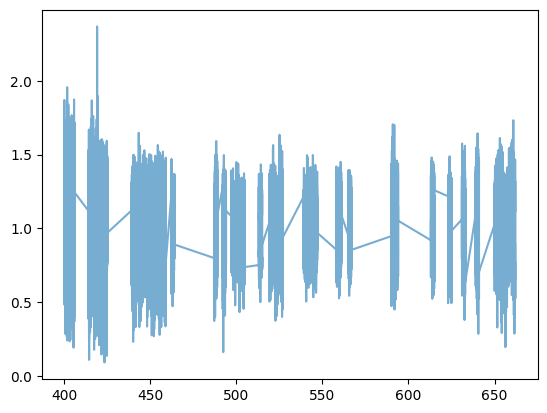

In [272]:
plt.plot(wl_load, flux_load, alpha=0.6)

In [142]:
wl3_shift = ops.vactoair(wl3) * doppler_shift1
snr_interp = interp1d(wl3_shift, snr, bounds_error=False)(wl_all_Fe_array)

(0.0, 50.0)

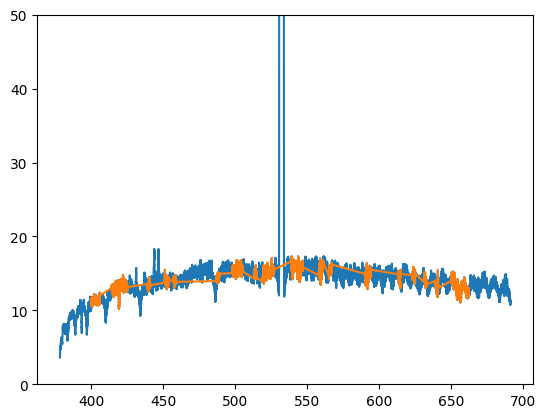

In [143]:
plt.plot(wl3_shift, snr)
plt.plot(wl_all_Fe_array, snr_interp)
plt.ylim(0, 50)

In [144]:
np.save("HARPS_snr_3transits_segment", snr_interp)

In [26]:
len(wl_load)

49495